- http://keunwoochoi.blogspot.com/2016/03/2.html
- http://www.rex-ai.info/docs/AI_Example_CNN_speech_recognize
- https://www.youtube.com/watch?v=oltGIc4uo5c
- https://youdaeng-com.tistory.com/5
- https://quokkas.tistory.com/37 : early stopping
- https://continuous-development.tistory.com/166 : stratified kfold
- https://deep-learning-study.tistory.com/476 fiter 시각화
- https://wyatt37.tistory.com/10 : random over sampling

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets
import cv2
from torchvision import transforms, datasets
import pandas as pd
import os
from glob import glob
import torchvision.models as models
import sys

p = os.path.abspath('../..') # 상위 폴더를 사용하기 위해서.
sys.path.insert(1, p)
from pytorchtools.pytorchtools import EarlyStopping # 상위 폴더에 추가된 모듈.


if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  1.10.2  Device :  cuda


In [2]:
import wandb

#default param
run_config = dict(
    # spectrum
    sr=16000,
    n_fft=1024,
    hop_length=300,
    win_length=1024,
    # training
    batch_size=32,
    # data
    fold=1,
)


In [3]:



sweep_config = {
    "project" : "SVD-hyp-stft",
    "name": "HyperParam for stft",
    "method": "grid",
    "parameters": {
        "sr":{
            "values":[16000,32000,50000]
        },
      "n_fft": {
            "values": np.arange(200,5120,50).tolist()
        },
      "win_length": {
            "values": np.arange(50,1048,50).tolist()
        },
       "hop_length": {
          "values": np.arange(50,850,50).tolist()
      },
      "fold":{
          "values" : [1,]
      }
    }
}

sweep_id = wandb.sweep(sweep_config)



Create sweep with ID: 5m81b7kd
Sweep URL: https://wandb.ai/bub3690/uncategorized/sweeps/5m81b7kd


In [44]:
np.arange(50,850,50).tolist()

[50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]

In [2]:
# n_fft
# ㅇ

sweep_config = {
    "project" : "SVD-voice-disorder",
    "name": "n_fft",
  "method": "grid",
  "parameters": {
      "n_fft": {
            "values": [512,1024,2048,3072,4096,8192,16384]
        },
      "fold":{
          "values" : [1,2,3,4,5]
      }
    }
}

sweep_id = wandb.sweep(sweep_config,project="SVD-hyp-sweep2",entity="bub3690")


Create sweep with ID: vls5boek
Sweep URL: https://wandb.ai/bub3690/SVD-hyp-sweep2/sweeps/vls5boek


In [5]:
# win_length

sweep_config = {
    "project" : "SVD-voice-disorder",
    "name": "win_length",
  "method": "grid",
  "parameters": {
      "win_length": {
            "values": [500,1024,1250,1524,2048,4096]
        },
      "fold":{
          "values" : [1,2,3,4,5]                                                     
      }
    }
}

sweep_id = wandb.sweep(sweep_config,project="SVD-hyp-sweep2",entity="bub3690")


Create sweep with ID: hy9bi35f
Sweep URL: https://wandb.ai/bub3690/SVD-hyp-sweep/sweeps/hy9bi35f


In [2]:
# hop_length

sweep_config = {
    "project" : "SVD-voice-disorder",
    "name": "hop_length",
  "method": "grid",
  "parameters": {
       "hop_length": {
          "values": [50,100,200,300,400,500,600]
      },
      "fold":{
          "values" : [1,2,3,4,5]
      }
    }
}

sweep_id = wandb.sweep(sweep_config,project="SVD-hyp-stft",entity="bub3690")


Create sweep with ID: vbxfcusk
Sweep URL: https://wandb.ai/bub3690/SVD-hyp-sweep/sweeps/vbxfcusk


# SVD 문장 데이터에서 Feature 추출
- mfcc

In [4]:
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt
#window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
#자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
#초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.
#sr=16000
#win_length =  np.int64(sr/40) # 1250
#n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
#hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.

# 데이터 나누기 - Stratified KFold

- pathology : 1194 / healthy : 634 / 총 1828
- k = 5

## 1. test/ train 나누기


In [5]:
#1. train, test 나누기

import os
from glob import glob
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import train_test_split # train , test 분리에 사용.


pathology = glob('D:/project/voice_pathology_ai/voice_data/organics/pathology/phrase/*.wav')
healthy = glob('D:/project/voice_pathology_ai/voice_data/organics/healthy/phrase/*.wav')
print("Pathology : ",len(pathology))
print("Healthy: ",len(healthy))

pathology= [ path.split("\\")[-1] for path in pathology] # path 데이터 변환.
healthy= [ path.split("\\")[-1] for path in healthy] # path 데이터 변환.
 # path 데이터 변환 #외부데이터로 가져오기위해서, 번호만 남긴다

    
X = pathology+healthy # path 데이터 합
print("총 데이터수 : ",len(X))
Y = [] # 라벨
for idx,x in enumerate(X):
    if idx<597:
        Y.append("pathology")
    else:
        Y.append("healthy")

X, X_test, Y, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, stratify=Y, random_state=456)
#stratify를 넣어서, test에도 라벨별 잘 분류되게 한다.

print("---")
print("훈련 셋 : ",len(Y),Counter(Y))
print("테스트 셋 : ",len(Y_test),Counter(Y_test))
print("---")

Pathology :  597
Healthy:  634
총 데이터수 :  1231
---
훈련 셋 :  984 Counter({'healthy': 507, 'pathology': 477})
테스트 셋 :  247 Counter({'healthy': 127, 'pathology': 120})
---


## 2. stratified k-fold

In [6]:
#1. train, test 나누기
#stratified kfold
import os
import random #데이터 shuffle 사용
from glob import glob
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from collections import Counter



skf_iris = StratifiedKFold(n_splits=5,shuffle=True,random_state=456)
cnt_iter = 0

X_train_list = [] #데이터 셋 보관
Y_train_list = []

X_valid_list = []
Y_valid_list = []

for train_idx, test_idx in skf_iris.split(X,Y):
    
    #split으로 반환된 인덱스를 이용하여, 학습 검증용 테스트 데이터 추출
    cnt_iter += 1
    X_train, X_valid = [X[idx] for idx in train_idx.tolist() ], [X[idx] for idx in test_idx.tolist() ]
    Y_train, Y_valid = [Y[idx] for idx in train_idx.tolist() ], [Y[idx] for idx in test_idx.tolist() ]
    
    X_train_list.append(X_train)
    X_valid_list.append(X_valid)
    
    Y_train_list.append(Y_train)
    Y_valid_list.append(Y_valid)
    
    
    #학습 및 예측
    
    label_train = Y_train
    label_test = Y_valid
    unique_train, train_counts = np.unique(label_train, return_counts = True)
    unique_test, test_counts = np.unique(label_test, return_counts = True)
    
    uniq_cnt_train = dict(zip(unique_train, train_counts))
    uniq_cnt_test = dict(zip(unique_test, test_counts))
    
    
    
    print('교차 검증 : {}'.format(cnt_iter))
    print('학습 레이블 데이터 분포 : \n', uniq_cnt_train)
    print('검증 레이블 데이터 분포 : \n', uniq_cnt_test,'\n')



교차 검증 : 1
학습 레이블 데이터 분포 : 
 {'healthy': 406, 'pathology': 381}
검증 레이블 데이터 분포 : 
 {'healthy': 101, 'pathology': 96} 

교차 검증 : 2
학습 레이블 데이터 분포 : 
 {'healthy': 406, 'pathology': 381}
검증 레이블 데이터 분포 : 
 {'healthy': 101, 'pathology': 96} 

교차 검증 : 3
학습 레이블 데이터 분포 : 
 {'healthy': 405, 'pathology': 382}
검증 레이블 데이터 분포 : 
 {'healthy': 102, 'pathology': 95} 

교차 검증 : 4
학습 레이블 데이터 분포 : 
 {'healthy': 405, 'pathology': 382}
검증 레이블 데이터 분포 : 
 {'healthy': 102, 'pathology': 95} 

교차 검증 : 5
학습 레이블 데이터 분포 : 
 {'healthy': 406, 'pathology': 382}
검증 레이블 데이터 분포 : 
 {'healthy': 101, 'pathology': 95} 



## 3. random over sampling

In [7]:
#2. random over sampling
for i in range(5):
    X_temp = np.array(X_train_list[i]).reshape(-1,1)#각 데이터를 다 행으로 넣음. (1194,1)
    #Y = np.array(Y)
    ros = RandomOverSampler(random_state = 123)
    X_res,Y_res = ros.fit_resample(X_temp,Y_train_list[i])
    
    print("\n fold{} ".format(i))
    print('before dataset shape {}'.format(Counter(Y_train_list[i])) )
    print('Resampled dataset shape {}'.format(Counter(Y_res)) )   
    
    #원래대로 돌리기
    X_res=X_res.reshape(1, -1)
    X_train_list[i]=X_res[0].tolist()
    Y_train_list[i]=Y_res





 fold0 
before dataset shape Counter({'healthy': 406, 'pathology': 381})
Resampled dataset shape Counter({'pathology': 406, 'healthy': 406})

 fold1 
before dataset shape Counter({'healthy': 406, 'pathology': 381})
Resampled dataset shape Counter({'healthy': 406, 'pathology': 406})

 fold2 
before dataset shape Counter({'healthy': 405, 'pathology': 382})
Resampled dataset shape Counter({'pathology': 405, 'healthy': 405})

 fold3 
before dataset shape Counter({'healthy': 405, 'pathology': 382})
Resampled dataset shape Counter({'pathology': 405, 'healthy': 405})

 fold4 
before dataset shape Counter({'healthy': 406, 'pathology': 382})
Resampled dataset shape Counter({'pathology': 406, 'healthy': 406})


In [8]:
import pickle

#16000 load
with open("D:/project/voice_pathology_ai/voice_data/organics/phrase_sig_dict.pickle","rb") as fr:
    phrase_dict_16000 = pickle.load(fr)

#32000 load
with open("D:/project/voice_pathology_ai/voice_data/organics/phrase_sig_dict_32000.pickle","rb") as fr:
    phrase_dict_32000 = pickle.load(fr)    

#50000 load
with open("D:/project/voice_pathology_ai/voice_data/organics/phrase_sig_dict_50000.pickle","rb") as fr:
    phrase_dict_50000 = pickle.load(fr)

    

# 데이터 정의
- 추가적으로 데이터의 크기를 맞춰주기 위해 3초로 padding 및 truncate 실시 https://sequencedata.tistory.com/25 FixAudioLength
- 논문에서는 400frame으로 설정.(여기서는 500frame)
- 전처리 방법 결정.


In [9]:
from torch.utils.data import Dataset, DataLoader

classes = ["healthy","pathology"]
#sr=50000
#win_length =  np.int64(16000/40) # 400
#n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding. 세로 길이
#hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.



class svd_dataset(Dataset):
    def __init__(self,data_path_list,classes,data_num,training,mel_params,transform=None,normalize=None):
        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        
        #data_num : k 개 데이터 셋 중 어떤것을 쓸지
        #test인지 아닌지.
        
        self.path_list = data_path_list[data_num]
        self.data_num = data_num
        self.training = training
        self.label = svd_dataset.get_label(self.path_list,training,data_num)
        self.classes = classes
        self.transform = transform
        self.normalize = normalize
        
        # sweep params
        self.mel_params = mel_params
        # hop_length , win_length , n_mels , n_fft , f_max , batch_size
        
        
    
    @classmethod
    def get_label(cls,data_path_list,training,data_num):
        label_list=[]
        
        if training:
            for idx,x in enumerate(data_path_list):
                label_list.append(Y_train_list[data_num][idx])
        else:
            for idx,x in enumerate(data_path_list):
                label_list.append(Y_valid_list[data_num][idx])
        #print(label_list)
        return label_list
    
    
    def __len__(self):
        return len(self.path_list)
        #데이터 셋의 길이를 정수로 반환한다.     
    
       
    def __getitem__(self, idx):
        """
        1. path를 받아서, 소리에서 mfcc를 추출
        2. mfcc를 224프레임으로 패딩.
        3. resnet에 사용되기 위해 3채널로 복사(rgb 처럼)
        4. 0~1 정규화
        
        """
        sig=None
        sample_f_max=None
        sample_win_length=None
        
        if self.mel_params["sr"] ==16000:
            sig = phrase_dict_16000[self.path_list[idx]]  
            
        elif self.mel_params["sr"] ==32000:
            sig = phrase_dict_32000[self.path_list[idx]]
            
        else:
            sig = phrase_dict_50000[self.path_list[idx]]
        
        length = self.mel_params['sr']*2 #300 padding을 위한 파라미터 (하이퍼 파라미터로인해 사이즈는 계속 바뀐다.)
        pad1d = lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))        
        sig = pad1d(sig,length)        
        
        ###signal norm
        sig = (sig-sig.mean())/sig.std()
        ###
        
        #win_size 조절
        if self.mel_params["win_length"] >self.mel_params["n_fft"]:
            sample_win_length=self.mel_params["n_fft"]        
        
        stft = librosa.stft(sig, win_length=sample_win_length,
                        n_fft=self.mel_params["n_fft"],
                        hop_length=self.mel_params["hop_length"]
                           )
        magnitude = np.abs(stft)
        log_spectrogram = librosa.amplitude_to_db(magnitude)        
                
        
        
        
        if self.transform:
            #print('transform')
            log_spectrogram=self.transform(log_spectrogram).type(torch.float32)# 데이터 0~1 정규화
            log_spectrogram=torch.stack([log_spectrogram,log_spectrogram,log_spectrogram])# 3채널로 복사.
            log_spectrogram = log_spectrogram.squeeze(dim=1)
            
            # global normalize
            if self.normalize:
                log_spectrogram=self.normalize(log_spectrogram)            
        else:
            #print("else")
            log_spectrogram = torch.from_numpy(log_spectrogram).type(torch.float32)
            log_spectrogram=log_spectrogram.unsqueeze(0)#cnn 사용위해서 추가
            #MFCCs = MFCCs.permute(2, 0, 1)
        return log_spectrogram, self.classes.index(self.label[idx])
    

In [10]:

# test set 제작을 위한 class
class svd_test_set(Dataset):
    def __init__(self,data_path_list,classes,mel_params,transform=None,normalize=None):
        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        
        #data_num : k 개 데이터 셋 중 어떤것을 쓸지
        #test인지 아닌지.
        
        self.path_list = data_path_list
        self.label = svd_test_set.get_label(self.path_list)
        self.classes=classes
        self.transform=transform
        self.normalize=normalize
        
        # sweep params
        self.mel_params = mel_params
        # hop_length , win_length , n_mels , n_fft , f_max , batch_size        
        
    
    @classmethod
    def get_label(cls,data_path_list):
        label_list=[]
        
        for idx,x in enumerate(data_path_list):
            label_list.append(Y_test[idx])
        #print(label_list)
        return label_list
    
    def __len__(self):
        return len(self.path_list)
        #데이터 셋의 길이를 정수로 반환한다. 
        
    def __getitem__(self, idx):
        """
        1. path를 받아서, 소리에서 mfcc를 추출
        2. mfcc를 224프레임으로 패딩.
        3. resnet에 사용되기 위해 3채널로 복사(rgb 처럼)
        4. 0~1 정규화
        
        """
        sig=None
        sample_f_max=None
        sample_win_length=None
        
        if self.mel_params["sr"] ==16000:
            sig = phrase_dict_16000[self.path_list[idx]]  
            
        elif self.mel_params["sr"] ==32000:
            sig = phrase_dict_32000[self.path_list[idx]]
            
        else:
            sig = phrase_dict_50000[self.path_list[idx]]
        
        length = self.mel_params['sr']*2 #300 padding을 위한 파라미터 (하이퍼 파라미터로인해 사이즈는 계속 바뀐다.)
        pad1d = lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))        
        sig = pad1d(sig,length)        
        
        ###signal norm
        sig = (sig-sig.mean())/sig.std()
        ###
        
        #win_size 조절
        if self.mel_params["win_length"] >self.mel_params["n_fft"]:
            sample_win_length=self.mel_params["n_fft"]        
        
        stft = librosa.stft(sig, win_length=sample_win_length,
                        n_fft=self.mel_params["n_fft"],
                        hop_length=self.mel_params["hop_length"]
                           )
        magnitude = np.abs(stft)
        log_spectrogram = librosa.amplitude_to_db(magnitude)        
                
        
        
        
        if self.transform:
            #print('transform')
            log_spectrogram=self.transform(log_spectrogram).type(torch.float32)# 데이터 0~1 정규화
            log_spectrogram=torch.stack([log_spectrogram,log_spectrogram,log_spectrogram])# 3채널로 복사.
            log_spectrogram = log_spectrogram.squeeze(dim=1)
            
            # global normalize
            if self.normalize:
                log_spectrogram=self.normalize(log_spectrogram)            
        else:
            #print("else")
            log_spectrogram = torch.from_numpy(log_spectrogram).type(torch.float32)
            log_spectrogram=log_spectrogram.unsqueeze(0)#cnn 사용위해서 추가
            #MFCCs = MFCCs.permute(2, 0, 1)
        return log_spectrogram, self.classes.index(self.label[idx])
    
    

# 데이터 로더

In [11]:
#3. 하이퍼 파라미터
BATCH_SIZE =  32 #한 배치당 32개 음성데이터
EPOCHS = 40 # 전체 데이터 셋을 50번 반복
lr=0.0001
augment_kind="no"


In [12]:
#DATA LOADER 함수가 BATCH_size 단위로 분리해 지정.

#확인을 위해 데이터셋 하나만 확인


train_loader = torch.utils.data.DataLoader(dataset = 
                                           svd_dataset(
                                               X_train_list,
                                               classes,
                                               transform = transforms.ToTensor(),#이걸 composed로 고쳐서 전처리 하도록 수정. to tensor는 -데이터는 노멀라이즈못함.
                                               #normalize=transforms.Normalize((-56.4917, -56.4917,-56.4917), (17.9446,17.9446,17.9446)),
                                               mel_params = dict(
                                                    sr = run_config['sr'],
                                                     n_fft = run_config["n_fft"],
                                                     win_length = run_config["win_length"],
                                                     hop_length = run_config["hop_length"],
                                               ),
                                               data_num=run_config["fold"],
                                               training=True
                                           ),
                                           batch_size = run_config["batch_size"],
                                           shuffle = True,
                                           ) # 순서가 암기되는것을 막기위해.

validation_loader = torch.utils.data.DataLoader(dataset = 
                                           svd_dataset(
                                               X_valid_list,
                                               classes,
                                               transform = transforms.ToTensor(),
                                               mel_params = dict(
                                                   sr = run_config['sr'],
                                                     n_fft = run_config["n_fft"],
                                                     win_length = run_config["win_length"],
                                                     hop_length = run_config["hop_length"],
                                               ),                      
                                               #normalize=transforms.Normalize((-56.4917, -56.4917,-56.4917), (17.9446,17.9446,17.9446)),                                               
                                               data_num=run_config["fold"],
                                               training=False
                                           ),
                                           batch_size = run_config["batch_size"],
                                           shuffle = True,) 



In [13]:
# 테스트 데이터 로더.

test_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_test_set(
                                                   X_test,
                                                   classes,
                                                   mel_params = dict(
                                                       sr = run_config['sr'],
                                                         n_fft = run_config["n_fft"],
                                                         win_length = run_config["win_length"],
                                                         hop_length = run_config["hop_length"],
                                               ),                                            
                                                   #normalize=transforms.Normalize((-56.4917, -56.4917,-56.4917), (17.9446,17.9446,17.9446)),                                                   
                                                   transform = transforms.ToTensor(),
                                               ),
                                               batch_size = run_config["batch_size"],
                                               shuffle = True,) 

# 데이터 확인

In [14]:

sr=16000
win_length =  run_config["win_length"] # 400
n_fft= run_config["n_fft"] # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding. 세로 길이
hop_length=run_config["hop_length"] #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.


X_train :  torch.Size([32, 3, 513, 107]) type: torch.FloatTensor
Y_train :  torch.Size([32]) type: torch.LongTensor
tensor(1)


Text(0.5, 1.0, 'log-STFT (dB)')

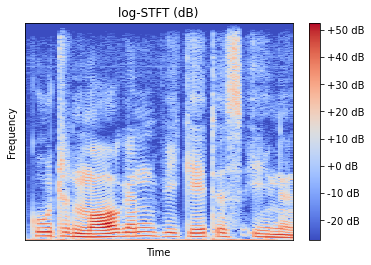

In [15]:
# 4. 데이터 확인하기
for (X_train,Y_train) in train_loader:
    print("X_train : ",X_train.size(),'type:',X_train.type())
    print("Y_train : ",Y_train.size(),'type:',Y_train.type())
    break
    
print(Y_train[0])
librosa.display.specshow(X_train[0][0].numpy(), sr=sr, hop_length=run_config["hop_length"])
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("log-STFT (dB)")
#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

X_valid :  torch.Size([32, 3, 513, 107]) type: torch.FloatTensor
Y_valid :  torch.Size([32]) type: torch.LongTensor
tensor(0)


Text(0.5, 1.0, 'stft (dB)')

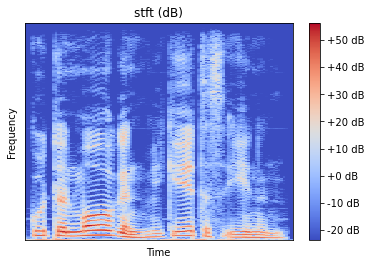

In [16]:
#valiation set 확인
for (X_valid,Y_valid) in validation_loader:
    print("X_valid : ",X_valid.size(),'type:',X_valid.type())
    print("Y_valid : ",Y_valid.size(),'type:',Y_valid.type())
    break

print(Y_valid[0])
librosa.display.specshow(X_valid[0][0].numpy(), sr=sr, hop_length=run_config["batch_size"])
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("stft (dB)")

#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

X_valid :  torch.Size([32, 3, 513, 107]) type: torch.FloatTensor
Y_valid :  torch.Size([32]) type: torch.LongTensor
tensor(0)


Text(0.5, 1.0, 'stft (dB)')

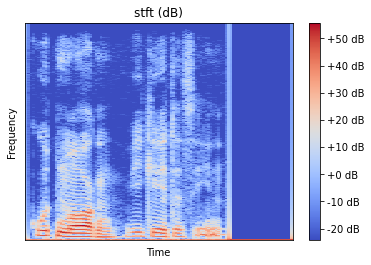

In [17]:
#valiation set 확인
for (test_data,test_label) in validation_loader:
    print("X_valid : ",test_data.size(),'type:',test_data.type())
    print("Y_valid : ",test_label.size(),'type:',test_label.type())
    break

print(Y_valid[0])
librosa.display.specshow(test_data[0][0].numpy(), sr=sr, hop_length=run_config["batch_size"])
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("stft (dB)")

#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

# RESNET

In [18]:
# 모델 
# pretrained


def model_initialize():
    model = models.resnet18(pretrained=True).cuda()
    model.ftrs = model.fc.in_features # in_features : fully connected의 입력수.
    num_ftrs = model.fc.in_features
    
    model.fc = nn.Sequential(nn.Linear(num_ftrs, 64),
                             nn.BatchNorm1d(64),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(64,50),
                             nn.BatchNorm1d(50),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(50,2)
                            )

    model = model.cuda()
    return model
model=model_initialize()


In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
# get the model summary
from torchsummary import summary
#summary(model, input_size=(3, 128, 300), device=DEVICE.type)

In [21]:
#8. 학습
def train(model,train_loader,optimizer, log_interval):
    model.train()    
    correct = 0
    train_loss = 0
    for batch_idx,(image,label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        #데이터들 장비에 할당
        optimizer.zero_grad() # device 에 저장된 gradient 제거
        output = model(image) # model로 output을 계산
        loss = criterion(output, label) #loss 계산
        train_loss += loss.item()
        prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
        correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
        loss.backward() # loss 값을 이용해 gradient를 계산
        optimizer.step() # Gradient 값을 이용해 파라미터 업데이트.
    train_loss/=len(train_loader.dataset)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss,train_accuracy


In [22]:
#9. 학습 진행하며, validation 데이터로 모델 성능확인
def evaluate(model,valid_loader):
    model.eval()
    valid_loss = 0
    correct = 0
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image, label in valid_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            valid_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
            #true.false값을 sum해줌. item
        valid_loss /= len(valid_loader.dataset)
        valid_accuracy = 100. * correct / len(valid_loader.dataset)
        return valid_loss,valid_accuracy


In [24]:
#데이터 로더 제작 함수

def load_data(data_ind):

    train_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_dataset(
                                                   X_train_list,
                                                   classes,
                                                   transform = transforms.ToTensor(),#이걸 composed로 고쳐서 전처리 하도록 수정. to tensor는 -데이터는 노멀라이즈못함.
                                                   #normalize=transforms.Normalize((-56.4917, -56.4917,-56.4917), (17.9446,17.9446,17.9446)),
                                                   mel_params = dict(
                                                         sr = wandb.config.sr,
                                                         n_fft = wandb.config.n_fft,
                                                         win_length = wandb.config.win_length,
                                                         hop_length = wandb.config.hop_length,
                                                   ),
                                                   data_num=data_ind,
                                                   training=True
                                               ),
                                               batch_size = wandb.config.batch_size,
                                               shuffle = True,
                                               ) # 순서가 암기되는것을 막기위해.

    validation_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_dataset(
                                                   X_valid_list,
                                                   classes,
                                                   transform = transforms.ToTensor(),
                                                   mel_params = dict(
                                                         sr = wandb.config.sr,
                                                         n_fft = wandb.config.n_fft,
                                                         win_length = wandb.config.win_length,
                                                         hop_length = wandb.config.hop_length,
                                                   ),                      
                                                   #normalize=transforms.Normalize((-56.4917, -56.4917,-56.4917), (17.9446,17.9446,17.9446)),                                               
                                                   data_num=data_ind,
                                                   training=False
                                               ),
                                               batch_size = wandb.config.batch_size,
                                               shuffle = True,) 

    return train_loader,validation_loader



In [25]:
#10. 학습 및 평가.
# resnet34 pretrained true
# kfold 적용

train_accs = []
valid_accs = []



def all_train():
    wandb.init(project="SVD-hyp-stft", entity="bub3690",config=run_config)
    #searching = "n_mels" ## 여기 수정 ##
    data_ind = wandb.config.fold
    check_path = '../../checkpoint/checkpoint_spectro_resnet18_true_ros_'+str(data_ind)+'_organics.pt'
    print(check_path)
    #wandb.run.name = '{} : {}'.format(searching,wandb.config.n_mels)  ### 여기 수정 ###
    print("config:", dict(wandb.config))    

    early_stopping = EarlyStopping(patience = 5, verbose = True, path=check_path)
    train_loader,validation_loader = load_data(data_ind-1)

    best_train_acc = 0 # accuracy 기록용
    best_valid_acc = 0
    
    best_train_loss = 0
    best_valid_loss = 0

    model=model_initialize()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)


    print("[{} 교차검증] 학습 시작\n ----- ".format(data_ind))
    for Epoch in range(1,EPOCHS+1):
        train_loss,train_accuracy=train(model,train_loader,optimizer,log_interval=31)
        valid_loss,valid_accuracy = evaluate(model, validation_loader)

        print("\n[EPOCH:{}]\t Train Loss:{:.4f}\t Train Acc:{:.2f} %  | \tValid Loss:{:.4f} \tValid Acc: {:.2f} %\n".
              format(Epoch,train_loss,train_accuracy,valid_loss,valid_accuracy))
        #wandb.log({"metric": run.config.param1, "epoch": epoch})
            
        early_stopping(valid_loss, model)
        if -early_stopping.best_score == valid_loss:
            best_train_acc, best_valid_acc = train_accuracy,valid_accuracy
            best_train_loss, best_valid_loss = train_loss,valid_loss
            
            wandb.log({"Valid/Loss": best_valid_loss, 
                       "Valid/Accuracy": best_valid_acc,
                      }, step=Epoch)
            #wandb.run.summary.update({"best_valid_{}fold_acc".format(data_ind) : best_valid_acc})
        else:
            # 이전 최고 기록을 log
            wandb.log({"Valid/Loss": best_valid_loss, 
                       "Valid/Accuracy": best_valid_acc,
                      }, step=Epoch)

        if early_stopping.early_stop:
                train_accs.append(best_train_acc)
                valid_accs.append(best_valid_acc)
                print("[{} 교차검증] Early stopping".format(data_ind))
                break

        if Epoch==EPOCHS:
            #만약 early stop 없이 40 epoch라서 중지 된 경우.
            train_accs.append(best_train_acc)
            valid_accs.append(best_valid_acc)

In [26]:
wandb.agent(sweep_id, function=all_train,count=100)

wandb: Agent Starting Run: cpdu3bvp with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 16000
wandb: 	win_length: 50
wandb: Currently logged in as: bub3690. Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 16000, 'n_fft': 200, 'hop_length': 50, 'win_length': 50, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0194	 Train Acc:67.49 %  | 	Valid Loss:0.0192 	Valid Acc: 77.16 %

Validation loss decreased (inf --> 0.019231).  Saving model ...

[EPOCH:2]	 Train Loss:0.0153	 Train Acc:79.19 %  | 	Valid Loss:0.0176 	Valid Acc: 78.17 %

Validation loss decreased (0.019231 --> 0.017554).  Saving model ...

[EPOCH:3]	 Train Loss:0.0135	 Train Acc:83.62 %  | 	Valid Loss:0.0165 	Valid Acc: 78.68 %

Validation loss decreased (0.017554 --> 0.016527).  Saving model ...

[EPOCH:4]	 Train Loss:0.0114	 Train Acc:89.53 %  | 	Valid Loss:0.0160 	Valid Acc: 80.20 %

Validation loss decreased (0.016527 --> 0.016045).  Saving model ...

[EPOCH:5]	 Train Loss:0.0095	 Train Acc:93.84 %  | 	Valid Loss:0.0153 	Valid Acc: 84.26 %

Validation loss decreased (0.016045 --> 0.015325).  Saving model ...

[EPOCH:

Valid/Accuracy,▁▂▃▄█▇██████
Valid/Loss,█▆▄▄▃▁▁▁▁▁▁▁
Valid/Accuracy,84.26396
Valid/Loss,0.01384


wandb: Agent Starting Run: hm392eee with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 16000
wandb: 	win_length: 100
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 16000, 'n_fft': 200, 'hop_length': 50, 'win_length': 100, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0206	 Train Acc:60.47 %  | 	Valid Loss:0.0203 	Valid Acc: 77.16 %

Validation loss decreased (inf --> 0.020268).  Saving model ...

[EPOCH:2]	 Train Loss:0.0173	 Train Acc:74.75 %  | 	Valid Loss:0.0185 	Valid Acc: 80.20 %

Validation loss decreased (0.020268 --> 0.018483).  Saving model ...

[EPOCH:3]	 Train Loss:0.0152	 Train Acc:80.91 %  | 	Valid Loss:0.0173 	Valid Acc: 78.68 %

Validation loss decreased (0.018483 --> 0.017338).  Saving model ...

[EPOCH:4]	 Train Loss:0.0140	 Train Acc:87.07 %  | 	Valid Loss:0.0178 	Valid Acc: 78.68 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0123	 Train Acc:90.39 %  | 	Valid Loss:0.0160 	Valid Acc: 83.76 %

Validation loss decreased (0.017338 --> 0.015988).  Saving model ...

[EPOCH:6]	 Train Loss:0.0104	 Train Acc:9

Valid/Accuracy,▁▄▂▂▇▇▅▄▇▅▅▅█▇▇▇▇▇▇
Valid/Loss,█▆▅▅▄▄▄▄▃▂▂▂▁▁▁▁▁▁▁
Valid/Accuracy,84.26396
Valid/Loss,0.01246


wandb: Agent Starting Run: 7cw9b2i6 with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 16000
wandb: 	win_length: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 16000, 'n_fft': 200, 'hop_length': 50, 'win_length': 150, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0190	 Train Acc:66.63 %  | 	Valid Loss:0.0189 	Valid Acc: 78.17 %

Validation loss decreased (inf --> 0.018850).  Saving model ...

[EPOCH:2]	 Train Loss:0.0150	 Train Acc:80.54 %  | 	Valid Loss:0.0172 	Valid Acc: 81.73 %

Validation loss decreased (0.018850 --> 0.017205).  Saving model ...

[EPOCH:3]	 Train Loss:0.0125	 Train Acc:85.47 %  | 	Valid Loss:0.0143 	Valid Acc: 83.25 %

Validation loss decreased (0.017205 --> 0.014308).  Saving model ...

[EPOCH:4]	 Train Loss:0.0110	 Train Acc:90.27 %  | 	Valid Loss:0.0146 	Valid Acc: 84.26 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0095	 Train Acc:94.33 %  | 	Valid Loss:0.0153 	Valid Acc: 85.28 %

EarlyStopping counter: 2 out of 5

[EPOCH:6]	 Train Loss:0.0080	 Train Acc:98.15 %  | 	Valid Loss:0.0141 	Valid

Valid/Accuracy,▁▄▅▅▅▃▃▄▄▇▇▇▇▇████▆▆▆▆▆▆
Valid/Loss,█▇▄▄▄▄▄▄▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Valid/Accuracy,84.77157
Valid/Loss,0.01038


wandb: Agent Starting Run: 8teluwln with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 16000
wandb: 	win_length: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 16000, 'n_fft': 200, 'hop_length': 50, 'win_length': 200, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0202	 Train Acc:62.93 %  | 	Valid Loss:0.0188 	Valid Acc: 69.54 %

Validation loss decreased (inf --> 0.018838).  Saving model ...

[EPOCH:2]	 Train Loss:0.0163	 Train Acc:75.74 %  | 	Valid Loss:0.0166 	Valid Acc: 73.60 %

Validation loss decreased (0.018838 --> 0.016648).  Saving model ...

[EPOCH:3]	 Train Loss:0.0140	 Train Acc:83.00 %  | 	Valid Loss:0.0147 	Valid Acc: 82.23 %

Validation loss decreased (0.016648 --> 0.014730).  Saving model ...

[EPOCH:4]	 Train Loss:0.0125	 Train Acc:87.44 %  | 	Valid Loss:0.0152 	Valid Acc: 82.23 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0105	 Train Acc:92.24 %  | 	Valid Loss:0.0146 	Valid Acc: 84.26 %

Validation loss decreased (0.014730 --> 0.014602).  Saving model ...

[EPOCH:6]	 Train Loss:0.0092	 Train Acc:9

Valid/Accuracy,▁▃▆▆▇▇██▆▆█████▇▇▇▇▇▇▇███████████
Valid/Loss,█▆▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Valid/Accuracy,85.7868
Valid/Loss,0.01075


wandb: Agent Starting Run: zthrch0v with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 16000
wandb: 	win_length: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 16000, 'n_fft': 200, 'hop_length': 50, 'win_length': 250, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0209	 Train Acc:63.55 %  | 	Valid Loss:0.0211 	Valid Acc: 69.54 %

Validation loss decreased (inf --> 0.021129).  Saving model ...

[EPOCH:2]	 Train Loss:0.0175	 Train Acc:74.88 %  | 	Valid Loss:0.0188 	Valid Acc: 76.65 %

Validation loss decreased (0.021129 --> 0.018837).  Saving model ...

[EPOCH:3]	 Train Loss:0.0149	 Train Acc:83.37 %  | 	Valid Loss:0.0176 	Valid Acc: 82.74 %

Validation loss decreased (0.018837 --> 0.017591).  Saving model ...

[EPOCH:4]	 Train Loss:0.0131	 Train Acc:86.70 %  | 	Valid Loss:0.0160 	Valid Acc: 84.77 %

Validation loss decreased (0.017591 --> 0.015971).  Saving model ...

[EPOCH:5]	 Train Loss:0.0114	 Train Acc:92.98 %  | 	Valid Loss:0.0151 	Valid Acc: 83.76 %

Validation loss decreased (0.015971 --> 0.015078).  Saving model ...

[EPOCH

Valid/Accuracy,▁▄▇▇▇▇█▇▇▇▆▇▇▇▇█▇▇▇▇▇▇▇▇██████
Valid/Loss,█▆▅▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Valid/Accuracy,86.29442
Valid/Loss,0.01162


wandb: Agent Starting Run: ix64fx3z with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 16000
wandb: 	win_length: 300
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 16000, 'n_fft': 200, 'hop_length': 50, 'win_length': 300, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0210	 Train Acc:59.98 %  | 	Valid Loss:0.0211 	Valid Acc: 75.13 %

Validation loss decreased (inf --> 0.021081).  Saving model ...

[EPOCH:2]	 Train Loss:0.0167	 Train Acc:76.60 %  | 	Valid Loss:0.0192 	Valid Acc: 77.16 %

Validation loss decreased (0.021081 --> 0.019168).  Saving model ...

[EPOCH:3]	 Train Loss:0.0149	 Train Acc:81.65 %  | 	Valid Loss:0.0177 	Valid Acc: 80.71 %

Validation loss decreased (0.019168 --> 0.017749).  Saving model ...

[EPOCH:4]	 Train Loss:0.0125	 Train Acc:88.42 %  | 	Valid Loss:0.0159 	Valid Acc: 79.70 %

Validation loss decreased (0.017749 --> 0.015891).  Saving model ...

[EPOCH:5]	 Train Loss:0.0116	 Train Acc:91.50 %  | 	Valid Loss:0.0164 	Valid Acc: 80.20 %

EarlyStopping counter: 1 out of 5

[EPOCH:6]	 Train Loss:0.0097	 Train Acc:9

Valid/Accuracy,▁▂▅▄▄▆▆▆▆▇▇███████████
Valid/Loss,█▆▅▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Valid/Accuracy,84.26396
Valid/Loss,0.0122


wandb: Agent Starting Run: 4jn8qha3 with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 16000
wandb: 	win_length: 350
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 16000, 'n_fft': 200, 'hop_length': 50, 'win_length': 350, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0202	 Train Acc:65.15 %  | 	Valid Loss:0.0205 	Valid Acc: 76.14 %

Validation loss decreased (inf --> 0.020508).  Saving model ...

[EPOCH:2]	 Train Loss:0.0163	 Train Acc:77.46 %  | 	Valid Loss:0.0178 	Valid Acc: 78.68 %

Validation loss decreased (0.020508 --> 0.017849).  Saving model ...

[EPOCH:3]	 Train Loss:0.0148	 Train Acc:83.13 %  | 	Valid Loss:0.0178 	Valid Acc: 80.71 %

Validation loss decreased (0.017849 --> 0.017798).  Saving model ...

[EPOCH:4]	 Train Loss:0.0130	 Train Acc:87.32 %  | 	Valid Loss:0.0163 	Valid Acc: 81.73 %

Validation loss decreased (0.017798 --> 0.016263).  Saving model ...

[EPOCH:5]	 Train Loss:0.0117	 Train Acc:91.01 %  | 	Valid Loss:0.0169 	Valid Acc: 80.71 %

EarlyStopping counter: 1 out of 5

[EPOCH:6]	 Train Loss:0.0102	 Train Acc:9

Valid/Accuracy,▁▃▅▆▆▅▆▆████▆▆▆▆▆██████
Valid/Loss,█▆▆▅▅▅▄▄▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,84.26396
Valid/Loss,0.0116


wandb: Agent Starting Run: i0k24pqq with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 16000
wandb: 	win_length: 400
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 16000, 'n_fft': 200, 'hop_length': 50, 'win_length': 400, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0199	 Train Acc:64.41 %  | 	Valid Loss:0.0197 	Valid Acc: 73.10 %

Validation loss decreased (inf --> 0.019704).  Saving model ...

[EPOCH:2]	 Train Loss:0.0149	 Train Acc:79.31 %  | 	Valid Loss:0.0174 	Valid Acc: 78.68 %

Validation loss decreased (0.019704 --> 0.017374).  Saving model ...

[EPOCH:3]	 Train Loss:0.0138	 Train Acc:81.65 %  | 	Valid Loss:0.0160 	Valid Acc: 79.19 %

Validation loss decreased (0.017374 --> 0.016001).  Saving model ...

[EPOCH:4]	 Train Loss:0.0118	 Train Acc:88.55 %  | 	Valid Loss:0.0158 	Valid Acc: 82.74 %

Validation loss decreased (0.016001 --> 0.015768).  Saving model ...

[EPOCH:5]	 Train Loss:0.0099	 Train Acc:93.10 %  | 	Valid Loss:0.0142 	Valid Acc: 83.25 %

Validation loss decreased (0.015768 --> 0.014180).  Saving model ...

[EPOCH

Valid/Accuracy,▁▄▅▇▇▇▇▇▇▇██████████
Valid/Loss,█▆▅▅▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,84.77157
Valid/Loss,0.0115


wandb: Agent Starting Run: qtqi9sj9 with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 16000
wandb: 	win_length: 450
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 16000, 'n_fft': 200, 'hop_length': 50, 'win_length': 450, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0192	 Train Acc:68.47 %  | 	Valid Loss:0.0188 	Valid Acc: 76.14 %

Validation loss decreased (inf --> 0.018840).  Saving model ...

[EPOCH:2]	 Train Loss:0.0152	 Train Acc:80.67 %  | 	Valid Loss:0.0172 	Valid Acc: 80.71 %

Validation loss decreased (0.018840 --> 0.017181).  Saving model ...

[EPOCH:3]	 Train Loss:0.0130	 Train Acc:87.19 %  | 	Valid Loss:0.0168 	Valid Acc: 81.22 %

Validation loss decreased (0.017181 --> 0.016840).  Saving model ...

[EPOCH:4]	 Train Loss:0.0108	 Train Acc:93.23 %  | 	Valid Loss:0.0163 	Valid Acc: 83.25 %

Validation loss decreased (0.016840 --> 0.016260).  Saving model ...

[EPOCH:5]	 Train Loss:0.0093	 Train Acc:96.67 %  | 	Valid Loss:0.0157 	Valid Acc: 80.71 %

Validation loss decreased (0.016260 --> 0.015744).  Saving model ...

[EPOCH

Valid/Accuracy,▁▅▆█▅▇▇▇▇▇▇▇▇▇▇▇▇▇██████
Valid/Loss,█▆▆▅▅▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,83.24873
Valid/Loss,0.01256


wandb: Agent Starting Run: wuwu21hq with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 16000
wandb: 	win_length: 500
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 16000, 'n_fft': 200, 'hop_length': 50, 'win_length': 500, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0203	 Train Acc:67.00 %  | 	Valid Loss:0.0196 	Valid Acc: 73.10 %

Validation loss decreased (inf --> 0.019563).  Saving model ...

[EPOCH:2]	 Train Loss:0.0157	 Train Acc:79.80 %  | 	Valid Loss:0.0158 	Valid Acc: 80.71 %

Validation loss decreased (0.019563 --> 0.015769).  Saving model ...

[EPOCH:3]	 Train Loss:0.0133	 Train Acc:87.81 %  | 	Valid Loss:0.0156 	Valid Acc: 84.26 %

Validation loss decreased (0.015769 --> 0.015629).  Saving model ...

[EPOCH:4]	 Train Loss:0.0116	 Train Acc:92.73 %  | 	Valid Loss:0.0156 	Valid Acc: 85.79 %

Validation loss decreased (0.015629 --> 0.015577).  Saving model ...

[EPOCH:5]	 Train Loss:0.0100	 Train Acc:95.57 %  | 	Valid Loss:0.0158 	Valid Acc: 85.79 %

EarlyStopping counter: 1 out of 5

[EPOCH:6]	 Train Loss:0.0086	 Train Acc:9

Valid/Accuracy,▁▅▇▇▇▇▇▇▇▇▇▇▇▇███████████
Valid/Loss,█▅▅▅▅▅▄▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Valid/Accuracy,86.80203
Valid/Loss,0.01076


wandb: Agent Starting Run: umy7ejrb with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 16000
wandb: 	win_length: 550
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 16000, 'n_fft': 200, 'hop_length': 50, 'win_length': 550, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0196	 Train Acc:65.64 %  | 	Valid Loss:0.0178 	Valid Acc: 78.17 %

Validation loss decreased (inf --> 0.017838).  Saving model ...

[EPOCH:2]	 Train Loss:0.0141	 Train Acc:81.90 %  | 	Valid Loss:0.0160 	Valid Acc: 80.71 %

Validation loss decreased (0.017838 --> 0.015999).  Saving model ...

[EPOCH:3]	 Train Loss:0.0124	 Train Acc:86.21 %  | 	Valid Loss:0.0156 	Valid Acc: 82.23 %

Validation loss decreased (0.015999 --> 0.015634).  Saving model ...

[EPOCH:4]	 Train Loss:0.0107	 Train Acc:90.64 %  | 	Valid Loss:0.0160 	Valid Acc: 80.71 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0092	 Train Acc:94.09 %  | 	Valid Loss:0.0148 	Valid Acc: 79.70 %

Validation loss decreased (0.015634 --> 0.014822).  Saving model ...

[EPOCH:6]	 Train Loss:0.0078	 Train Acc:9

Valid/Accuracy,▁▄▆▆▃▃▆▆███▅▅▅▅▅▅
Valid/Loss,█▆▅▅▄▄▄▃▃▃▃▁▁▁▁▁▁
Valid/Accuracy,81.21827
Valid/Loss,0.01231


wandb: Agent Starting Run: 5lrskrmm with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 16000
wandb: 	win_length: 600
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 16000, 'n_fft': 200, 'hop_length': 50, 'win_length': 600, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0204	 Train Acc:62.32 %  | 	Valid Loss:0.0200 	Valid Acc: 71.57 %

Validation loss decreased (inf --> 0.020014).  Saving model ...

[EPOCH:2]	 Train Loss:0.0166	 Train Acc:73.52 %  | 	Valid Loss:0.0170 	Valid Acc: 77.16 %

Validation loss decreased (0.020014 --> 0.017029).  Saving model ...

[EPOCH:3]	 Train Loss:0.0149	 Train Acc:78.33 %  | 	Valid Loss:0.0167 	Valid Acc: 79.70 %

Validation loss decreased (0.017029 --> 0.016729).  Saving model ...

[EPOCH:4]	 Train Loss:0.0132	 Train Acc:83.87 %  | 	Valid Loss:0.0171 	Valid Acc: 78.68 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0114	 Train Acc:89.53 %  | 	Valid Loss:0.0165 	Valid Acc: 80.71 %

Validation loss decreased (0.016729 --> 0.016511).  Saving model ...

[EPOCH:6]	 Train Loss:0.0099	 Train Acc:9

Valid/Accuracy,▁▄▅▅▅▆▇▇▆▆▇▇▇▇▇████████████
Valid/Loss,█▆▆▆▅▄▄▃▃▃▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁
Valid/Accuracy,86.29442
Valid/Loss,0.01057


wandb: Agent Starting Run: m8dvtn7b with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 16000
wandb: 	win_length: 650
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 16000, 'n_fft': 200, 'hop_length': 50, 'win_length': 650, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0206	 Train Acc:62.81 %  | 	Valid Loss:0.0196 	Valid Acc: 72.59 %

Validation loss decreased (inf --> 0.019563).  Saving model ...

[EPOCH:2]	 Train Loss:0.0163	 Train Acc:76.60 %  | 	Valid Loss:0.0178 	Valid Acc: 79.70 %

Validation loss decreased (0.019563 --> 0.017809).  Saving model ...

[EPOCH:3]	 Train Loss:0.0143	 Train Acc:82.27 %  | 	Valid Loss:0.0170 	Valid Acc: 80.20 %

Validation loss decreased (0.017809 --> 0.016986).  Saving model ...

[EPOCH:4]	 Train Loss:0.0127	 Train Acc:87.07 %  | 	Valid Loss:0.0159 	Valid Acc: 82.74 %

Validation loss decreased (0.016986 --> 0.015941).  Saving model ...

[EPOCH:5]	 Train Loss:0.0106	 Train Acc:92.86 %  | 	Valid Loss:0.0154 	Valid Acc: 81.22 %

Validation loss decreased (0.015941 --> 0.015419).  Saving model ...

[EPOCH

Valid/Accuracy,▁▅▅▆▆▇█████▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Valid/Loss,█▆▆▅▄▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Valid/Accuracy,83.24873
Valid/Loss,0.01161


wandb: Agent Starting Run: j7p0yx6g with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 16000
wandb: 	win_length: 700
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 16000, 'n_fft': 200, 'hop_length': 50, 'win_length': 700, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0200	 Train Acc:64.66 %  | 	Valid Loss:0.0187 	Valid Acc: 75.13 %

Validation loss decreased (inf --> 0.018725).  Saving model ...

[EPOCH:2]	 Train Loss:0.0153	 Train Acc:80.54 %  | 	Valid Loss:0.0173 	Valid Acc: 79.70 %

Validation loss decreased (0.018725 --> 0.017282).  Saving model ...

[EPOCH:3]	 Train Loss:0.0137	 Train Acc:83.74 %  | 	Valid Loss:0.0162 	Valid Acc: 75.63 %

Validation loss decreased (0.017282 --> 0.016205).  Saving model ...

[EPOCH:4]	 Train Loss:0.0117	 Train Acc:89.04 %  | 	Valid Loss:0.0172 	Valid Acc: 80.71 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0101	 Train Acc:92.86 %  | 	Valid Loss:0.0154 	Valid Acc: 82.23 %

Validation loss decreased (0.016205 --> 0.015383).  Saving model ...

[EPOCH:6]	 Train Loss:0.0090	 Train Acc:9

Valid/Accuracy,▁▅▁▁██▆▆▆▆▆▆▆▆▆▆▆
Valid/Loss,█▆▅▅▄▄▂▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,80.20305
Valid/Loss,0.01309


wandb: Agent Starting Run: jpk62aof with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 16000
wandb: 	win_length: 750
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 16000, 'n_fft': 200, 'hop_length': 50, 'win_length': 750, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0224	 Train Acc:62.44 %  | 	Valid Loss:0.0206 	Valid Acc: 70.05 %

Validation loss decreased (inf --> 0.020625).  Saving model ...

[EPOCH:2]	 Train Loss:0.0157	 Train Acc:76.72 %  | 	Valid Loss:0.0184 	Valid Acc: 74.62 %

Validation loss decreased (0.020625 --> 0.018376).  Saving model ...

[EPOCH:3]	 Train Loss:0.0136	 Train Acc:82.51 %  | 	Valid Loss:0.0181 	Valid Acc: 76.14 %

Validation loss decreased (0.018376 --> 0.018095).  Saving model ...

[EPOCH:4]	 Train Loss:0.0119	 Train Acc:87.32 %  | 	Valid Loss:0.0160 	Valid Acc: 78.68 %

Validation loss decreased (0.018095 --> 0.016016).  Saving model ...

[EPOCH:5]	 Train Loss:0.0100	 Train Acc:92.61 %  | 	Valid Loss:0.0152 	Valid Acc: 80.20 %

Validation loss decreased (0.016016 --> 0.015200).  Saving model ...

[EPOCH

Valid/Accuracy,▁▄▅▆▇▇▇▇█████▇▇▇▇▇▇
Valid/Loss,█▆▅▃▃▃▃▃▂▁▁▁▁▁▁▁▁▁▁
Valid/Accuracy,80.71066
Valid/Loss,0.01355


wandb: Agent Starting Run: yt9jzexs with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 16000
wandb: 	win_length: 800
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 16000, 'n_fft': 200, 'hop_length': 50, 'win_length': 800, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0218	 Train Acc:57.76 %  | 	Valid Loss:0.0212 	Valid Acc: 69.54 %

Validation loss decreased (inf --> 0.021245).  Saving model ...

[EPOCH:2]	 Train Loss:0.0175	 Train Acc:74.14 %  | 	Valid Loss:0.0187 	Valid Acc: 79.19 %

Validation loss decreased (0.021245 --> 0.018653).  Saving model ...

[EPOCH:3]	 Train Loss:0.0153	 Train Acc:81.03 %  | 	Valid Loss:0.0173 	Valid Acc: 81.22 %

Validation loss decreased (0.018653 --> 0.017320).  Saving model ...

[EPOCH:4]	 Train Loss:0.0142	 Train Acc:85.10 %  | 	Valid Loss:0.0166 	Valid Acc: 81.22 %

Validation loss decreased (0.017320 --> 0.016561).  Saving model ...

[EPOCH:5]	 Train Loss:0.0122	 Train Acc:89.53 %  | 	Valid Loss:0.0155 	Valid Acc: 81.73 %

Validation loss decreased (0.016561 --> 0.015453).  Saving model ...

[EPOCH

Valid/Accuracy,▁▅▅▅▆▆▇▇▇▆▆▇█████████
Valid/Loss,█▆▅▅▄▄▄▃▃▃▃▃▂▂▂▁▁▁▁▁▁
Valid/Accuracy,86.80203
Valid/Loss,0.01083


wandb: Agent Starting Run: 9brsmpox with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 16000
wandb: 	win_length: 850
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 16000, 'n_fft': 200, 'hop_length': 50, 'win_length': 850, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0206	 Train Acc:62.68 %  | 	Valid Loss:0.0216 	Valid Acc: 73.10 %

Validation loss decreased (inf --> 0.021586).  Saving model ...

[EPOCH:2]	 Train Loss:0.0160	 Train Acc:75.74 %  | 	Valid Loss:0.0183 	Valid Acc: 80.71 %

Validation loss decreased (0.021586 --> 0.018259).  Saving model ...

[EPOCH:3]	 Train Loss:0.0133	 Train Acc:81.40 %  | 	Valid Loss:0.0163 	Valid Acc: 78.68 %

Validation loss decreased (0.018259 --> 0.016334).  Saving model ...

[EPOCH:4]	 Train Loss:0.0113	 Train Acc:89.78 %  | 	Valid Loss:0.0164 	Valid Acc: 80.71 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0096	 Train Acc:94.21 %  | 	Valid Loss:0.0158 	Valid Acc: 81.22 %

Validation loss decreased (0.016334 --> 0.015778).  Saving model ...

[EPOCH:6]	 Train Loss:0.0086	 Train Acc:9

Valid/Accuracy,▁▇▅▅▇█████████
Valid/Loss,█▅▄▄▃▂▂▂▁▁▁▁▁▁
Valid/Accuracy,81.72589
Valid/Loss,0.01304


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wvtcf4p2 with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 16000
wandb: 	win_length: 900
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 16000, 'n_fft': 200, 'hop_length': 50, 'win_length': 900, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0198	 Train Acc:63.18 %  | 	Valid Loss:0.0187 	Valid Acc: 77.16 %

Validation loss decreased (inf --> 0.018716).  Saving model ...

[EPOCH:2]	 Train Loss:0.0154	 Train Acc:78.20 %  | 	Valid Loss:0.0176 	Valid Acc: 77.66 %

Validation loss decreased (0.018716 --> 0.017573).  Saving model ...

[EPOCH:3]	 Train Loss:0.0135	 Train Acc:83.99 %  | 	Valid Loss:0.0158 	Valid Acc: 82.74 %

Validation loss decreased (0.017573 --> 0.015844).  Saving model ...

[EPOCH:4]	 Train Loss:0.0115	 Train Acc:90.27 %  | 	Valid Loss:0.0156 	Valid Acc: 80.20 %

Validation loss decreased (0.015844 --> 0.015640).  Saving model ...

[EPOCH:5]	 Train Loss:0.0105	 Train Acc:92.98 %  | 	Valid Loss:0.0144 	Valid Acc: 84.26 %

Validation loss decreased (0.015640 --> 0.014363).  Saving model ...

[EPOCH

Valid/Accuracy,▁▁▆▃▇▇▇▆▆▆▆▆███████████
Valid/Loss,█▇▆▅▄▄▄▄▄▄▄▃▃▃▃▃▃▁▁▁▁▁▁
Valid/Accuracy,85.27919
Valid/Loss,0.01059


wandb: Agent Starting Run: aznld5f0 with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 16000
wandb: 	win_length: 950
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 16000, 'n_fft': 200, 'hop_length': 50, 'win_length': 950, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0201	 Train Acc:63.18 %  | 	Valid Loss:0.0190 	Valid Acc: 70.56 %

Validation loss decreased (inf --> 0.018996).  Saving model ...

[EPOCH:2]	 Train Loss:0.0163	 Train Acc:78.82 %  | 	Valid Loss:0.0169 	Valid Acc: 78.68 %

Validation loss decreased (0.018996 --> 0.016906).  Saving model ...

[EPOCH:3]	 Train Loss:0.0144	 Train Acc:81.65 %  | 	Valid Loss:0.0168 	Valid Acc: 79.70 %

Validation loss decreased (0.016906 --> 0.016828).  Saving model ...

[EPOCH:4]	 Train Loss:0.0126	 Train Acc:88.42 %  | 	Valid Loss:0.0155 	Valid Acc: 81.73 %

Validation loss decreased (0.016828 --> 0.015541).  Saving model ...

[EPOCH:5]	 Train Loss:0.0105	 Train Acc:92.24 %  | 	Valid Loss:0.0153 	Valid Acc: 81.73 %

Validation loss decreased (0.015541 --> 0.015252).  Saving model ...

[EPOCH

Valid/Accuracy,▁▄▅▅▅▆▆▆▇▇▇▆▆▆███████
Valid/Loss,█▆▆▅▅▄▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁
Valid/Accuracy,87.30964
Valid/Loss,0.01117


wandb: Agent Starting Run: bmeo06be with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 16000
wandb: 	win_length: 1000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 16000, 'n_fft': 200, 'hop_length': 50, 'win_length': 1000, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0215	 Train Acc:62.56 %  | 	Valid Loss:0.0203 	Valid Acc: 71.57 %

Validation loss decreased (inf --> 0.020253).  Saving model ...

[EPOCH:2]	 Train Loss:0.0164	 Train Acc:73.65 %  | 	Valid Loss:0.0173 	Valid Acc: 78.17 %

Validation loss decreased (0.020253 --> 0.017295).  Saving model ...

[EPOCH:3]	 Train Loss:0.0147	 Train Acc:78.08 %  | 	Valid Loss:0.0163 	Valid Acc: 78.68 %

Validation loss decreased (0.017295 --> 0.016341).  Saving model ...

[EPOCH:4]	 Train Loss:0.0126	 Train Acc:85.34 %  | 	Valid Loss:0.0155 	Valid Acc: 79.19 %

Validation loss decreased (0.016341 --> 0.015535).  Saving model ...

[EPOCH:5]	 Train Loss:0.0102	 Train Acc:91.50 %  | 	Valid Loss:0.0150 	Valid Acc: 82.74 %

Validation loss decreased (0.015535 --> 0.014983).  Saving model ...

[EPOC

Valid/Accuracy,▁▅▅▅▇▇▇▇████▇▇▇▇▇▇
Valid/Loss,█▅▄▄▃▃▃▃▁▁▁▁▁▁▁▁▁▁
Valid/Accuracy,82.2335
Valid/Loss,0.01255


wandb: Agent Starting Run: tzcet16c with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 32000
wandb: 	win_length: 50
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 32000, 'n_fft': 200, 'hop_length': 50, 'win_length': 50, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0205	 Train Acc:63.79 %  | 	Valid Loss:0.0199 	Valid Acc: 75.63 %

Validation loss decreased (inf --> 0.019872).  Saving model ...

[EPOCH:2]	 Train Loss:0.0162	 Train Acc:76.35 %  | 	Valid Loss:0.0151 	Valid Acc: 78.17 %

Validation loss decreased (0.019872 --> 0.015057).  Saving model ...

[EPOCH:3]	 Train Loss:0.0141	 Train Acc:81.40 %  | 	Valid Loss:0.0156 	Valid Acc: 81.73 %

EarlyStopping counter: 1 out of 5

[EPOCH:4]	 Train Loss:0.0119	 Train Acc:87.32 %  | 	Valid Loss:0.0152 	Valid Acc: 80.71 %

EarlyStopping counter: 2 out of 5

[EPOCH:5]	 Train Loss:0.0099	 Train Acc:92.98 %  | 	Valid Loss:0.0154 	Valid Acc: 81.22 %

EarlyStopping counter: 3 out of 5

[EPOCH:6]	 Train Loss:0.0086	 Train Acc:95.07 %  | 	Valid Loss:0.0137 	Valid Acc: 79.19 %

Validation loss decre

Valid/Accuracy,▁▃▃▃▃▄▄▃▃▃▇▇█▅▅▅▅▆▆▇▇▇▇▇▇
Valid/Loss,█▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,83.24873
Valid/Loss,0.01165


wandb: Agent Starting Run: jqbm1xa5 with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 32000
wandb: 	win_length: 100
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 32000, 'n_fft': 200, 'hop_length': 50, 'win_length': 100, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0203	 Train Acc:63.05 %  | 	Valid Loss:0.0198 	Valid Acc: 68.53 %

Validation loss decreased (inf --> 0.019787).  Saving model ...

[EPOCH:2]	 Train Loss:0.0164	 Train Acc:77.34 %  | 	Valid Loss:0.0184 	Valid Acc: 74.11 %

Validation loss decreased (0.019787 --> 0.018412).  Saving model ...

[EPOCH:3]	 Train Loss:0.0149	 Train Acc:83.25 %  | 	Valid Loss:0.0169 	Valid Acc: 81.73 %

Validation loss decreased (0.018412 --> 0.016938).  Saving model ...

[EPOCH:4]	 Train Loss:0.0130	 Train Acc:86.58 %  | 	Valid Loss:0.0161 	Valid Acc: 82.23 %

Validation loss decreased (0.016938 --> 0.016069).  Saving model ...

[EPOCH:5]	 Train Loss:0.0114	 Train Acc:90.89 %  | 	Valid Loss:0.0157 	Valid Acc: 81.73 %

Validation loss decreased (0.016069 --> 0.015660).  Saving model ...

[EPOCH

Valid/Accuracy,▁▃▆▇▆▆█▇██████████
Valid/Loss,█▇▅▅▄▄▄▃▃▃▂▂▁▁▁▁▁▁
Valid/Accuracy,85.7868
Valid/Loss,0.01213


wandb: Agent Starting Run: tu2apt0f with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 32000
wandb: 	win_length: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 32000, 'n_fft': 200, 'hop_length': 50, 'win_length': 150, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0206	 Train Acc:62.56 %  | 	Valid Loss:0.0202 	Valid Acc: 75.13 %

Validation loss decreased (inf --> 0.020159).  Saving model ...

[EPOCH:2]	 Train Loss:0.0160	 Train Acc:75.86 %  | 	Valid Loss:0.0177 	Valid Acc: 76.14 %

Validation loss decreased (0.020159 --> 0.017657).  Saving model ...

[EPOCH:3]	 Train Loss:0.0142	 Train Acc:81.65 %  | 	Valid Loss:0.0165 	Valid Acc: 78.68 %

Validation loss decreased (0.017657 --> 0.016500).  Saving model ...

[EPOCH:4]	 Train Loss:0.0127	 Train Acc:86.08 %  | 	Valid Loss:0.0163 	Valid Acc: 81.22 %

Validation loss decreased (0.016500 --> 0.016346).  Saving model ...

[EPOCH:5]	 Train Loss:0.0110	 Train Acc:91.26 %  | 	Valid Loss:0.0171 	Valid Acc: 78.68 %

EarlyStopping counter: 1 out of 5

[EPOCH:6]	 Train Loss:0.0101	 Train Acc:9

Valid/Accuracy,▁▂▄▆▆▅▅▅▅▅▇▇▆▆▆▆▆███████
Valid/Loss,█▆▅▅▅▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Valid/Accuracy,84.26396
Valid/Loss,0.01206


wandb: Agent Starting Run: ssjdymbr with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 32000
wandb: 	win_length: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 32000, 'n_fft': 200, 'hop_length': 50, 'win_length': 200, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0208	 Train Acc:63.92 %  | 	Valid Loss:0.0199 	Valid Acc: 73.60 %

Validation loss decreased (inf --> 0.019909).  Saving model ...

[EPOCH:2]	 Train Loss:0.0161	 Train Acc:77.46 %  | 	Valid Loss:0.0159 	Valid Acc: 77.16 %

Validation loss decreased (0.019909 --> 0.015930).  Saving model ...

[EPOCH:3]	 Train Loss:0.0141	 Train Acc:80.30 %  | 	Valid Loss:0.0156 	Valid Acc: 77.66 %

Validation loss decreased (0.015930 --> 0.015598).  Saving model ...

[EPOCH:4]	 Train Loss:0.0123	 Train Acc:85.71 %  | 	Valid Loss:0.0148 	Valid Acc: 81.22 %

Validation loss decreased (0.015598 --> 0.014758).  Saving model ...

[EPOCH:5]	 Train Loss:0.0100	 Train Acc:92.49 %  | 	Valid Loss:0.0147 	Valid Acc: 79.70 %

Validation loss decreased (0.014758 --> 0.014686).  Saving model ...

[EPOCH

Valid/Accuracy,▁▃▄▆▅▅▅████▅▅██████
Valid/Loss,█▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,83.75635
Valid/Loss,0.01217


wandb: Agent Starting Run: s5sifjcy with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 32000
wandb: 	win_length: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 32000, 'n_fft': 200, 'hop_length': 50, 'win_length': 250, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0199	 Train Acc:64.53 %  | 	Valid Loss:0.0207 	Valid Acc: 65.99 %

Validation loss decreased (inf --> 0.020684).  Saving model ...

[EPOCH:2]	 Train Loss:0.0161	 Train Acc:74.01 %  | 	Valid Loss:0.0188 	Valid Acc: 73.10 %

Validation loss decreased (0.020684 --> 0.018813).  Saving model ...

[EPOCH:3]	 Train Loss:0.0148	 Train Acc:80.42 %  | 	Valid Loss:0.0168 	Valid Acc: 78.17 %

Validation loss decreased (0.018813 --> 0.016801).  Saving model ...

[EPOCH:4]	 Train Loss:0.0128	 Train Acc:85.47 %  | 	Valid Loss:0.0162 	Valid Acc: 81.22 %

Validation loss decreased (0.016801 --> 0.016203).  Saving model ...

[EPOCH:5]	 Train Loss:0.0111	 Train Acc:88.42 %  | 	Valid Loss:0.0156 	Valid Acc: 82.74 %

Validation loss decreased (0.016203 --> 0.015581).  Saving model ...

[EPOCH

Valid/Accuracy,▁▄▅▆▇████████
Valid/Loss,█▆▄▄▃▁▁▁▁▁▁▁▁
Valid/Accuracy,85.7868
Valid/Loss,0.01315


wandb: Agent Starting Run: 079eownq with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 32000
wandb: 	win_length: 300
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 32000, 'n_fft': 200, 'hop_length': 50, 'win_length': 300, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0209	 Train Acc:62.56 %  | 	Valid Loss:0.0205 	Valid Acc: 71.57 %

Validation loss decreased (inf --> 0.020464).  Saving model ...

[EPOCH:2]	 Train Loss:0.0173	 Train Acc:71.31 %  | 	Valid Loss:0.0187 	Valid Acc: 76.14 %

Validation loss decreased (0.020464 --> 0.018719).  Saving model ...

[EPOCH:3]	 Train Loss:0.0151	 Train Acc:78.69 %  | 	Valid Loss:0.0166 	Valid Acc: 79.70 %

Validation loss decreased (0.018719 --> 0.016575).  Saving model ...

[EPOCH:4]	 Train Loss:0.0125	 Train Acc:85.47 %  | 	Valid Loss:0.0143 	Valid Acc: 83.76 %

Validation loss decreased (0.016575 --> 0.014343).  Saving model ...

[EPOCH:5]	 Train Loss:0.0110	 Train Acc:88.18 %  | 	Valid Loss:0.0143 	Valid Acc: 81.73 %

Validation loss decreased (0.014343 --> 0.014295).  Saving model ...

[EPOCH

Valid/Accuracy,▁▃▅▆▆█████▇██████
Valid/Loss,█▇▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁
Valid/Accuracy,86.80203
Valid/Loss,0.01149


wandb: Agent Starting Run: 82tha6d1 with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 32000
wandb: 	win_length: 350
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 32000, 'n_fft': 200, 'hop_length': 50, 'win_length': 350, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0200	 Train Acc:64.04 %  | 	Valid Loss:0.0203 	Valid Acc: 77.16 %

Validation loss decreased (inf --> 0.020296).  Saving model ...

[EPOCH:2]	 Train Loss:0.0168	 Train Acc:74.88 %  | 	Valid Loss:0.0169 	Valid Acc: 78.17 %

Validation loss decreased (0.020296 --> 0.016926).  Saving model ...

[EPOCH:3]	 Train Loss:0.0152	 Train Acc:80.17 %  | 	Valid Loss:0.0184 	Valid Acc: 76.14 %

EarlyStopping counter: 1 out of 5

[EPOCH:4]	 Train Loss:0.0135	 Train Acc:84.24 %  | 	Valid Loss:0.0158 	Valid Acc: 80.71 %

Validation loss decreased (0.016926 --> 0.015781).  Saving model ...

[EPOCH:5]	 Train Loss:0.0122	 Train Acc:89.04 %  | 	Valid Loss:0.0140 	Valid Acc: 84.26 %

Validation loss decreased (0.015781 --> 0.014007).  Saving model ...

[EPOCH:6]	 Train Loss:0.0104	 Train Acc:9

Valid/Accuracy,▁▂▂▅██████
Valid/Loss,█▄▄▃▁▁▁▁▁▁
Valid/Accuracy,84.26396
Valid/Loss,0.01401


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wy7jqn26 with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 32000
wandb: 	win_length: 400
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 32000, 'n_fft': 200, 'hop_length': 50, 'win_length': 400, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0196	 Train Acc:66.13 %  | 	Valid Loss:0.0186 	Valid Acc: 76.14 %

Validation loss decreased (inf --> 0.018645).  Saving model ...

[EPOCH:2]	 Train Loss:0.0151	 Train Acc:77.59 %  | 	Valid Loss:0.0173 	Valid Acc: 76.65 %

Validation loss decreased (0.018645 --> 0.017349).  Saving model ...

[EPOCH:3]	 Train Loss:0.0134	 Train Acc:84.98 %  | 	Valid Loss:0.0173 	Valid Acc: 79.19 %

Validation loss decreased (0.017349 --> 0.017287).  Saving model ...

[EPOCH:4]	 Train Loss:0.0115	 Train Acc:87.56 %  | 	Valid Loss:0.0148 	Valid Acc: 82.23 %

Validation loss decreased (0.017287 --> 0.014819).  Saving model ...

[EPOCH:5]	 Train Loss:0.0095	 Train Acc:92.98 %  | 	Valid Loss:0.0140 	Valid Acc: 83.25 %

Validation loss decreased (0.014819 --> 0.013976).  Saving model ...

[EPOCH

Valid/Accuracy,▁▁▃▅▅▆▆▆▆▅▅▅▅▅▆▆▆▆▆▆██████
Valid/Loss,█▇▇▅▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,87.81726
Valid/Loss,0.01025


wandb: Agent Starting Run: 82wlx3zc with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 32000
wandb: 	win_length: 450
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 32000, 'n_fft': 200, 'hop_length': 50, 'win_length': 450, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0208	 Train Acc:61.70 %  | 	Valid Loss:0.0199 	Valid Acc: 73.60 %

Validation loss decreased (inf --> 0.019864).  Saving model ...

[EPOCH:2]	 Train Loss:0.0166	 Train Acc:74.26 %  | 	Valid Loss:0.0177 	Valid Acc: 79.19 %

Validation loss decreased (0.019864 --> 0.017722).  Saving model ...

[EPOCH:3]	 Train Loss:0.0149	 Train Acc:79.93 %  | 	Valid Loss:0.0159 	Valid Acc: 78.17 %

Validation loss decreased (0.017722 --> 0.015901).  Saving model ...

[EPOCH:4]	 Train Loss:0.0132	 Train Acc:84.98 %  | 	Valid Loss:0.0145 	Valid Acc: 84.77 %

Validation loss decreased (0.015901 --> 0.014468).  Saving model ...

[EPOCH:5]	 Train Loss:0.0113	 Train Acc:91.01 %  | 	Valid Loss:0.0148 	Valid Acc: 81.73 %

EarlyStopping counter: 1 out of 5

[EPOCH:6]	 Train Loss:0.0098	 Train Acc:9

Valid/Accuracy,▁▄▃▇▇▇▇▇█▆██████
Valid/Loss,█▆▅▄▄▄▃▃▂▂▁▁▁▁▁▁
Valid/Accuracy,87.81726
Valid/Loss,0.01105


wandb: Agent Starting Run: igck57jf with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 32000
wandb: 	win_length: 500
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 32000, 'n_fft': 200, 'hop_length': 50, 'win_length': 500, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0192	 Train Acc:66.01 %  | 	Valid Loss:0.0204 	Valid Acc: 70.05 %

Validation loss decreased (inf --> 0.020358).  Saving model ...

[EPOCH:2]	 Train Loss:0.0161	 Train Acc:76.11 %  | 	Valid Loss:0.0179 	Valid Acc: 77.16 %

Validation loss decreased (0.020358 --> 0.017900).  Saving model ...

[EPOCH:3]	 Train Loss:0.0139	 Train Acc:84.73 %  | 	Valid Loss:0.0168 	Valid Acc: 81.73 %

Validation loss decreased (0.017900 --> 0.016814).  Saving model ...

[EPOCH:4]	 Train Loss:0.0126	 Train Acc:87.32 %  | 	Valid Loss:0.0154 	Valid Acc: 83.76 %

Validation loss decreased (0.016814 --> 0.015418).  Saving model ...

[EPOCH:5]	 Train Loss:0.0107	 Train Acc:92.61 %  | 	Valid Loss:0.0160 	Valid Acc: 82.23 %

EarlyStopping counter: 1 out of 5

[EPOCH:6]	 Train Loss:0.0092	 Train Acc:9

Valid/Accuracy,▁▄▆▇▇▇▇▇███▇▇█▆███▇▇▇▇▇▇
Valid/Loss,█▆▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,83.75635
Valid/Loss,0.01093


wandb: Agent Starting Run: 0b2nqdyw with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 32000
wandb: 	win_length: 550
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 32000, 'n_fft': 200, 'hop_length': 50, 'win_length': 550, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0202	 Train Acc:63.55 %  | 	Valid Loss:0.0201 	Valid Acc: 71.57 %

Validation loss decreased (inf --> 0.020083).  Saving model ...

[EPOCH:2]	 Train Loss:0.0161	 Train Acc:75.62 %  | 	Valid Loss:0.0160 	Valid Acc: 79.19 %

Validation loss decreased (0.020083 --> 0.015984).  Saving model ...

[EPOCH:3]	 Train Loss:0.0137	 Train Acc:82.51 %  | 	Valid Loss:0.0166 	Valid Acc: 79.19 %

EarlyStopping counter: 1 out of 5

[EPOCH:4]	 Train Loss:0.0120	 Train Acc:88.18 %  | 	Valid Loss:0.0147 	Valid Acc: 82.23 %

Validation loss decreased (0.015984 --> 0.014665).  Saving model ...

[EPOCH:5]	 Train Loss:0.0104	 Train Acc:92.12 %  | 	Valid Loss:0.0135 	Valid Acc: 82.74 %

Validation loss decreased (0.014665 --> 0.013535).  Saving model ...

[EPOCH:6]	 Train Loss:0.0088	 Train Acc:9

Valid/Accuracy,▁▅▅▆▆▆▆▇▇▇▇████▇▇▇▇▇▇▇▇▇
Valid/Loss,█▅▅▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,85.27919
Valid/Loss,0.01086


wandb: Agent Starting Run: tthx1h1l with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 32000
wandb: 	win_length: 600
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 32000, 'n_fft': 200, 'hop_length': 50, 'win_length': 600, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0194	 Train Acc:66.75 %  | 	Valid Loss:0.0194 	Valid Acc: 72.08 %

Validation loss decreased (inf --> 0.019400).  Saving model ...

[EPOCH:2]	 Train Loss:0.0150	 Train Acc:78.08 %  | 	Valid Loss:0.0158 	Valid Acc: 81.22 %

Validation loss decreased (0.019400 --> 0.015772).  Saving model ...

[EPOCH:3]	 Train Loss:0.0127	 Train Acc:85.59 %  | 	Valid Loss:0.0155 	Valid Acc: 83.76 %

Validation loss decreased (0.015772 --> 0.015480).  Saving model ...

[EPOCH:4]	 Train Loss:0.0115	 Train Acc:89.53 %  | 	Valid Loss:0.0154 	Valid Acc: 82.23 %

Validation loss decreased (0.015480 --> 0.015441).  Saving model ...

[EPOCH:5]	 Train Loss:0.0094	 Train Acc:96.80 %  | 	Valid Loss:0.0148 	Valid Acc: 84.77 %

Validation loss decreased (0.015441 --> 0.014781).  Saving model ...

[EPOCH

Valid/Accuracy,▁▆▇▇█▇▇▇▇▇▇
Valid/Loss,█▃▃▃▂▁▁▁▁▁▁
Valid/Accuracy,83.24873
Valid/Loss,0.01422


wandb: Agent Starting Run: p6t423yb with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 32000
wandb: 	win_length: 650
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 32000, 'n_fft': 200, 'hop_length': 50, 'win_length': 650, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0198	 Train Acc:65.76 %  | 	Valid Loss:0.0191 	Valid Acc: 70.56 %

Validation loss decreased (inf --> 0.019082).  Saving model ...

[EPOCH:2]	 Train Loss:0.0153	 Train Acc:78.69 %  | 	Valid Loss:0.0169 	Valid Acc: 77.66 %

Validation loss decreased (0.019082 --> 0.016879).  Saving model ...

[EPOCH:3]	 Train Loss:0.0143	 Train Acc:82.14 %  | 	Valid Loss:0.0154 	Valid Acc: 77.66 %

Validation loss decreased (0.016879 --> 0.015382).  Saving model ...

[EPOCH:4]	 Train Loss:0.0121	 Train Acc:86.21 %  | 	Valid Loss:0.0159 	Valid Acc: 78.68 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0102	 Train Acc:92.12 %  | 	Valid Loss:0.0157 	Valid Acc: 81.73 %

EarlyStopping counter: 2 out of 5

[EPOCH:6]	 Train Loss:0.0088	 Train Acc:94.33 %  | 	Valid Loss:0.0151 	Valid

Valid/Accuracy,▁▄▄▄▄▇▇▇▆▆▆▆▆▆██▇▇▇▇▇▇
Valid/Loss,█▆▅▅▅▄▄▄▃▃▃▃▃▃▃▂▁▁▁▁▁▁
Valid/Accuracy,84.26396
Valid/Loss,0.01154


wandb: Agent Starting Run: tveo5yu6 with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 32000
wandb: 	win_length: 700
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 32000, 'n_fft': 200, 'hop_length': 50, 'win_length': 700, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0191	 Train Acc:66.63 %  | 	Valid Loss:0.0195 	Valid Acc: 75.63 %

Validation loss decreased (inf --> 0.019456).  Saving model ...

[EPOCH:2]	 Train Loss:0.0156	 Train Acc:78.69 %  | 	Valid Loss:0.0170 	Valid Acc: 79.19 %

Validation loss decreased (0.019456 --> 0.017046).  Saving model ...

[EPOCH:3]	 Train Loss:0.0139	 Train Acc:82.64 %  | 	Valid Loss:0.0158 	Valid Acc: 81.22 %

Validation loss decreased (0.017046 --> 0.015844).  Saving model ...

[EPOCH:4]	 Train Loss:0.0121	 Train Acc:87.68 %  | 	Valid Loss:0.0164 	Valid Acc: 80.71 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0108	 Train Acc:91.26 %  | 	Valid Loss:0.0134 	Valid Acc: 82.74 %

Validation loss decreased (0.015844 --> 0.013437).  Saving model ...

[EPOCH:6]	 Train Loss:0.0089	 Train Acc:9

Valid/Accuracy,▁▃▄▄▅▅▆▆▆▅▅▅▅▅███████
Valid/Loss,█▆▅▅▃▃▃▃▃▃▃▃▃▃▁▁▁▁▁▁▁
Valid/Accuracy,87.30964
Valid/Loss,0.01059


wandb: Agent Starting Run: mx07867d with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 32000
wandb: 	win_length: 750
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 32000, 'n_fft': 200, 'hop_length': 50, 'win_length': 750, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0197	 Train Acc:66.50 %  | 	Valid Loss:0.0178 	Valid Acc: 74.62 %

Validation loss decreased (inf --> 0.017776).  Saving model ...

[EPOCH:2]	 Train Loss:0.0158	 Train Acc:75.25 %  | 	Valid Loss:0.0160 	Valid Acc: 75.63 %

Validation loss decreased (0.017776 --> 0.015977).  Saving model ...

[EPOCH:3]	 Train Loss:0.0132	 Train Acc:83.00 %  | 	Valid Loss:0.0151 	Valid Acc: 81.22 %

Validation loss decreased (0.015977 --> 0.015063).  Saving model ...

[EPOCH:4]	 Train Loss:0.0114	 Train Acc:88.67 %  | 	Valid Loss:0.0162 	Valid Acc: 81.22 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0099	 Train Acc:92.98 %  | 	Valid Loss:0.0150 	Valid Acc: 81.73 %

Validation loss decreased (0.015063 --> 0.015014).  Saving model ...

[EPOCH:6]	 Train Loss:0.0084	 Train Acc:9

Valid/Accuracy,▁▂▆▆▆▆▆███▇█████▇▇██████████
Valid/Loss,█▆▅▅▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Valid/Accuracy,84.77157
Valid/Loss,0.01163


wandb: Agent Starting Run: glqd7ast with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 32000
wandb: 	win_length: 800
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 32000, 'n_fft': 200, 'hop_length': 50, 'win_length': 800, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0193	 Train Acc:65.39 %  | 	Valid Loss:0.0198 	Valid Acc: 72.59 %

Validation loss decreased (inf --> 0.019760).  Saving model ...

[EPOCH:2]	 Train Loss:0.0161	 Train Acc:74.38 %  | 	Valid Loss:0.0171 	Valid Acc: 76.65 %

Validation loss decreased (0.019760 --> 0.017098).  Saving model ...

[EPOCH:3]	 Train Loss:0.0137	 Train Acc:82.76 %  | 	Valid Loss:0.0172 	Valid Acc: 78.17 %

EarlyStopping counter: 1 out of 5

[EPOCH:4]	 Train Loss:0.0121	 Train Acc:88.79 %  | 	Valid Loss:0.0154 	Valid Acc: 79.19 %

Validation loss decreased (0.017098 --> 0.015396).  Saving model ...

[EPOCH:5]	 Train Loss:0.0102	 Train Acc:93.60 %  | 	Valid Loss:0.0157 	Valid Acc: 80.71 %

EarlyStopping counter: 1 out of 5

[EPOCH:6]	 Train Loss:0.0091	 Train Acc:94.83 %  | 	Valid Loss:0.0143 	Valid

Valid/Accuracy,▁▃▃▅▅███▇▇███████
Valid/Loss,█▆▆▄▄▃▃▃▃▂▁▁▁▁▁▁▁
Valid/Accuracy,85.27919
Valid/Loss,0.01167


wandb: Agent Starting Run: cr21xn8p with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 32000
wandb: 	win_length: 850
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 32000, 'n_fft': 200, 'hop_length': 50, 'win_length': 850, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0217	 Train Acc:59.48 %  | 	Valid Loss:0.0210 	Valid Acc: 62.94 %

Validation loss decreased (inf --> 0.021020).  Saving model ...

[EPOCH:2]	 Train Loss:0.0174	 Train Acc:72.41 %  | 	Valid Loss:0.0177 	Valid Acc: 77.16 %

Validation loss decreased (0.021020 --> 0.017748).  Saving model ...

[EPOCH:3]	 Train Loss:0.0152	 Train Acc:79.68 %  | 	Valid Loss:0.0181 	Valid Acc: 80.20 %

EarlyStopping counter: 1 out of 5

[EPOCH:4]	 Train Loss:0.0134	 Train Acc:82.64 %  | 	Valid Loss:0.0147 	Valid Acc: 81.73 %

Validation loss decreased (0.017748 --> 0.014733).  Saving model ...

[EPOCH:5]	 Train Loss:0.0111	 Train Acc:91.13 %  | 	Valid Loss:0.0159 	Valid Acc: 79.19 %

EarlyStopping counter: 1 out of 5

[EPOCH:6]	 Train Loss:0.0094	 Train Acc:96.06 %  | 	Valid Loss:0.0152 	Valid

Valid/Accuracy,▁▆▆██████
Valid/Loss,█▄▄▁▁▁▁▁▁
Valid/Accuracy,81.72589
Valid/Loss,0.01473


wandb: Agent Starting Run: uus5l73y with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 32000
wandb: 	win_length: 900
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 32000, 'n_fft': 200, 'hop_length': 50, 'win_length': 900, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0200	 Train Acc:64.90 %  | 	Valid Loss:0.0201 	Valid Acc: 73.60 %

Validation loss decreased (inf --> 0.020103).  Saving model ...

[EPOCH:2]	 Train Loss:0.0158	 Train Acc:78.08 %  | 	Valid Loss:0.0173 	Valid Acc: 78.68 %

Validation loss decreased (0.020103 --> 0.017311).  Saving model ...

[EPOCH:3]	 Train Loss:0.0138	 Train Acc:83.87 %  | 	Valid Loss:0.0163 	Valid Acc: 80.71 %

Validation loss decreased (0.017311 --> 0.016283).  Saving model ...

[EPOCH:4]	 Train Loss:0.0122	 Train Acc:88.30 %  | 	Valid Loss:0.0147 	Valid Acc: 82.23 %

Validation loss decreased (0.016283 --> 0.014727).  Saving model ...

[EPOCH:5]	 Train Loss:0.0104	 Train Acc:92.24 %  | 	Valid Loss:0.0141 	Valid Acc: 82.74 %

Validation loss decreased (0.014727 --> 0.014116).  Saving model ...

[EPOCH

Valid/Accuracy,▁▃▄▅▅▅▇▇▇▆▆▆▆▇▇▇▇▇██████
Valid/Loss,█▆▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,88.83249
Valid/Loss,0.00976


wandb: Agent Starting Run: y1jk72gp with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 32000
wandb: 	win_length: 950
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 32000, 'n_fft': 200, 'hop_length': 50, 'win_length': 950, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0202	 Train Acc:64.90 %  | 	Valid Loss:0.0187 	Valid Acc: 74.11 %

Validation loss decreased (inf --> 0.018724).  Saving model ...

[EPOCH:2]	 Train Loss:0.0157	 Train Acc:77.34 %  | 	Valid Loss:0.0170 	Valid Acc: 77.66 %

Validation loss decreased (0.018724 --> 0.016975).  Saving model ...

[EPOCH:3]	 Train Loss:0.0142	 Train Acc:81.65 %  | 	Valid Loss:0.0170 	Valid Acc: 79.70 %

EarlyStopping counter: 1 out of 5

[EPOCH:4]	 Train Loss:0.0120	 Train Acc:88.05 %  | 	Valid Loss:0.0168 	Valid Acc: 80.20 %

Validation loss decreased (0.016975 --> 0.016799).  Saving model ...

[EPOCH:5]	 Train Loss:0.0100	 Train Acc:93.47 %  | 	Valid Loss:0.0153 	Valid Acc: 83.25 %

Validation loss decreased (0.016799 --> 0.015281).  Saving model ...

[EPOCH:6]	 Train Loss:0.0094	 Train Acc:9

Valid/Accuracy,▁▃▃▅▇▇▇▇▇██▇▇▇▇▇▅▆▆▆▆▆▆▆▆▆▆
Valid/Loss,█▆▆▆▅▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,82.74112
Valid/Loss,0.01144


wandb: Agent Starting Run: ialsbwtw with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 32000
wandb: 	win_length: 1000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 32000, 'n_fft': 200, 'hop_length': 50, 'win_length': 1000, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0191	 Train Acc:68.84 %  | 	Valid Loss:0.0180 	Valid Acc: 74.62 %

Validation loss decreased (inf --> 0.017976).  Saving model ...

[EPOCH:2]	 Train Loss:0.0152	 Train Acc:79.56 %  | 	Valid Loss:0.0176 	Valid Acc: 76.65 %

Validation loss decreased (0.017976 --> 0.017583).  Saving model ...

[EPOCH:3]	 Train Loss:0.0137	 Train Acc:84.73 %  | 	Valid Loss:0.0162 	Valid Acc: 80.20 %

Validation loss decreased (0.017583 --> 0.016180).  Saving model ...

[EPOCH:4]	 Train Loss:0.0124	 Train Acc:85.84 %  | 	Valid Loss:0.0164 	Valid Acc: 75.13 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0104	 Train Acc:91.63 %  | 	Valid Loss:0.0165 	Valid Acc: 82.74 %

EarlyStopping counter: 2 out of 5

[EPOCH:6]	 Train Loss:0.0089	 Train Acc:95.44 %  | 	Valid Loss:0.0151 	Vali

Valid/Accuracy,▁▂▅▅▅▅▅▅▅▆▆▇▇▇▇████████
Valid/Loss,██▆▆▆▅▅▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,83.75635
Valid/Loss,0.01172


wandb: Agent Starting Run: 5tnjfziu with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 50000
wandb: 	win_length: 50
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 50000, 'n_fft': 200, 'hop_length': 50, 'win_length': 50, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0201	 Train Acc:64.78 %  | 	Valid Loss:0.0198 	Valid Acc: 76.14 %

Validation loss decreased (inf --> 0.019763).  Saving model ...

[EPOCH:2]	 Train Loss:0.0169	 Train Acc:75.86 %  | 	Valid Loss:0.0174 	Valid Acc: 78.68 %

Validation loss decreased (0.019763 --> 0.017357).  Saving model ...

[EPOCH:3]	 Train Loss:0.0155	 Train Acc:80.17 %  | 	Valid Loss:0.0169 	Valid Acc: 82.74 %

Validation loss decreased (0.017357 --> 0.016872).  Saving model ...

[EPOCH:4]	 Train Loss:0.0136	 Train Acc:85.47 %  | 	Valid Loss:0.0171 	Valid Acc: 80.20 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0123	 Train Acc:87.93 %  | 	Valid Loss:0.0158 	Valid Acc: 78.17 %

Validation loss decreased (0.016872 --> 0.015778).  Saving model ...

[EPOCH:6]	 Train Loss:0.0107	 Train Acc:92

Valid/Accuracy,▁▃▇▇▃██████
Valid/Loss,█▅▄▄▂▁▁▁▁▁▁
Valid/Accuracy,84.26396
Valid/Loss,0.01476


wandb: Agent Starting Run: mh9o19in with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 50000
wandb: 	win_length: 100
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 50000, 'n_fft': 200, 'hop_length': 50, 'win_length': 100, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0206	 Train Acc:63.18 %  | 	Valid Loss:0.0195 	Valid Acc: 74.11 %

Validation loss decreased (inf --> 0.019533).  Saving model ...

[EPOCH:2]	 Train Loss:0.0167	 Train Acc:75.62 %  | 	Valid Loss:0.0180 	Valid Acc: 76.14 %

Validation loss decreased (0.019533 --> 0.017963).  Saving model ...

[EPOCH:3]	 Train Loss:0.0150	 Train Acc:79.43 %  | 	Valid Loss:0.0172 	Valid Acc: 80.20 %

Validation loss decreased (0.017963 --> 0.017200).  Saving model ...

[EPOCH:4]	 Train Loss:0.0134	 Train Acc:85.34 %  | 	Valid Loss:0.0158 	Valid Acc: 81.22 %

Validation loss decreased (0.017200 --> 0.015765).  Saving model ...

[EPOCH:5]	 Train Loss:0.0117	 Train Acc:90.02 %  | 	Valid Loss:0.0175 	Valid Acc: 78.68 %

EarlyStopping counter: 1 out of 5

[EPOCH:6]	 Train Loss:0.0102	 Train Acc:9

Valid/Accuracy,▁▂▅▅▅▆▆▆▅▅▅▇████████▇▇▇▇▇▇
Valid/Loss,█▇▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Valid/Accuracy,84.26396
Valid/Loss,0.01173


wandb: Agent Starting Run: xcf3krvy with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 50000
wandb: 	win_length: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 50000, 'n_fft': 200, 'hop_length': 50, 'win_length': 150, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0196	 Train Acc:65.15 %  | 	Valid Loss:0.0184 	Valid Acc: 77.66 %

Validation loss decreased (inf --> 0.018417).  Saving model ...

[EPOCH:2]	 Train Loss:0.0158	 Train Acc:79.06 %  | 	Valid Loss:0.0171 	Valid Acc: 78.68 %

Validation loss decreased (0.018417 --> 0.017145).  Saving model ...

[EPOCH:3]	 Train Loss:0.0135	 Train Acc:84.98 %  | 	Valid Loss:0.0163 	Valid Acc: 77.16 %

Validation loss decreased (0.017145 --> 0.016275).  Saving model ...

[EPOCH:4]	 Train Loss:0.0121	 Train Acc:89.53 %  | 	Valid Loss:0.0153 	Valid Acc: 81.22 %

Validation loss decreased (0.016275 --> 0.015274).  Saving model ...

[EPOCH:5]	 Train Loss:0.0106	 Train Acc:93.72 %  | 	Valid Loss:0.0164 	Valid Acc: 82.74 %

EarlyStopping counter: 1 out of 5

[EPOCH:6]	 Train Loss:0.0089	 Train Acc:9

Valid/Accuracy,▁▂▁▅▅▅▄▄██████████████
Valid/Loss,█▇▆▅▅▅▅▄▄▄▄▂▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,85.27919
Valid/Loss,0.01136


wandb: Agent Starting Run: rdblwvuj with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 50000
wandb: 	win_length: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 50000, 'n_fft': 200, 'hop_length': 50, 'win_length': 200, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0209	 Train Acc:59.11 %  | 	Valid Loss:0.0216 	Valid Acc: 76.65 %

Validation loss decreased (inf --> 0.021640).  Saving model ...

[EPOCH:2]	 Train Loss:0.0174	 Train Acc:73.77 %  | 	Valid Loss:0.0176 	Valid Acc: 78.17 %

Validation loss decreased (0.021640 --> 0.017582).  Saving model ...

[EPOCH:3]	 Train Loss:0.0160	 Train Acc:76.11 %  | 	Valid Loss:0.0165 	Valid Acc: 79.19 %

Validation loss decreased (0.017582 --> 0.016526).  Saving model ...

[EPOCH:4]	 Train Loss:0.0142	 Train Acc:84.11 %  | 	Valid Loss:0.0148 	Valid Acc: 79.70 %

Validation loss decreased (0.016526 --> 0.014818).  Saving model ...

[EPOCH:5]	 Train Loss:0.0128	 Train Acc:86.08 %  | 	Valid Loss:0.0168 	Valid Acc: 82.74 %

EarlyStopping counter: 1 out of 5

[EPOCH:6]	 Train Loss:0.0111	 Train Acc:9

Valid/Accuracy,▁▂▃▃▃▃██▆▆▆▆▆▇▇▇▇▇▆▆▆▆▆▆
Valid/Loss,█▅▅▄▄▄▃▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁
Valid/Accuracy,83.75635
Valid/Loss,0.01092


wandb: Agent Starting Run: h4vb5lpt with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 50000
wandb: 	win_length: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 50000, 'n_fft': 200, 'hop_length': 50, 'win_length': 250, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0204	 Train Acc:62.68 %  | 	Valid Loss:0.0191 	Valid Acc: 77.66 %

Validation loss decreased (inf --> 0.019089).  Saving model ...

[EPOCH:2]	 Train Loss:0.0166	 Train Acc:75.99 %  | 	Valid Loss:0.0159 	Valid Acc: 80.20 %

Validation loss decreased (0.019089 --> 0.015921).  Saving model ...

[EPOCH:3]	 Train Loss:0.0142	 Train Acc:84.11 %  | 	Valid Loss:0.0157 	Valid Acc: 81.73 %

Validation loss decreased (0.015921 --> 0.015657).  Saving model ...

[EPOCH:4]	 Train Loss:0.0130	 Train Acc:87.81 %  | 	Valid Loss:0.0152 	Valid Acc: 80.20 %

Validation loss decreased (0.015657 --> 0.015201).  Saving model ...

[EPOCH:5]	 Train Loss:0.0109	 Train Acc:91.75 %  | 	Valid Loss:0.0149 	Valid Acc: 82.23 %

Validation loss decreased (0.015201 --> 0.014911).  Saving model ...

[EPOCH

Valid/Accuracy,▁▃▄▃▄▄▄▄▅▅▇▇▇██▇▇▇▇▇▇
Valid/Loss,█▅▅▅▄▄▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,85.7868
Valid/Loss,0.01131


wandb: Agent Starting Run: n4jxn0e8 with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 50000
wandb: 	win_length: 300
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 50000, 'n_fft': 200, 'hop_length': 50, 'win_length': 300, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0212	 Train Acc:61.08 %  | 	Valid Loss:0.0213 	Valid Acc: 76.14 %

Validation loss decreased (inf --> 0.021295).  Saving model ...

[EPOCH:2]	 Train Loss:0.0172	 Train Acc:74.75 %  | 	Valid Loss:0.0188 	Valid Acc: 78.68 %

Validation loss decreased (0.021295 --> 0.018798).  Saving model ...

[EPOCH:3]	 Train Loss:0.0155	 Train Acc:79.80 %  | 	Valid Loss:0.0178 	Valid Acc: 78.68 %

Validation loss decreased (0.018798 --> 0.017822).  Saving model ...

[EPOCH:4]	 Train Loss:0.0143	 Train Acc:83.25 %  | 	Valid Loss:0.0171 	Valid Acc: 79.19 %

Validation loss decreased (0.017822 --> 0.017089).  Saving model ...

[EPOCH:5]	 Train Loss:0.0123	 Train Acc:89.90 %  | 	Valid Loss:0.0169 	Valid Acc: 75.63 %

Validation loss decreased (0.017089 --> 0.016927).  Saving model ...

[EPOCH

Valid/Accuracy,▁▃▃▃▁▆▆▆▆▆▆▇▆▆▆▆████▇▇▇▇██████
Valid/Loss,█▆▆▅▅▅▄▄▄▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Valid/Accuracy,85.7868
Valid/Loss,0.0115


wandb: Agent Starting Run: teniel35 with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 50000
wandb: 	win_length: 350
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 50000, 'n_fft': 200, 'hop_length': 50, 'win_length': 350, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0194	 Train Acc:64.29 %  | 	Valid Loss:0.0185 	Valid Acc: 74.62 %

Validation loss decreased (inf --> 0.018452).  Saving model ...

[EPOCH:2]	 Train Loss:0.0151	 Train Acc:78.82 %  | 	Valid Loss:0.0162 	Valid Acc: 78.17 %

Validation loss decreased (0.018452 --> 0.016183).  Saving model ...

[EPOCH:3]	 Train Loss:0.0131	 Train Acc:84.48 %  | 	Valid Loss:0.0161 	Valid Acc: 79.19 %

Validation loss decreased (0.016183 --> 0.016071).  Saving model ...

[EPOCH:4]	 Train Loss:0.0117	 Train Acc:86.70 %  | 	Valid Loss:0.0152 	Valid Acc: 79.70 %

Validation loss decreased (0.016071 --> 0.015152).  Saving model ...

[EPOCH:5]	 Train Loss:0.0104	 Train Acc:91.75 %  | 	Valid Loss:0.0152 	Valid Acc: 81.22 %

EarlyStopping counter: 1 out of 5

[EPOCH:6]	 Train Loss:0.0087	 Train Acc:9

Valid/Accuracy,▁▃▄▄▄▄▇▇▇▇▆▆▆▆▆█████▇▇██████
Valid/Loss,█▆▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,86.80203
Valid/Loss,0.01037


wandb: Agent Starting Run: znkmdkf3 with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 50000
wandb: 	win_length: 400
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 50000, 'n_fft': 200, 'hop_length': 50, 'win_length': 400, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0221	 Train Acc:59.36 %  | 	Valid Loss:0.0233 	Valid Acc: 61.42 %

Validation loss decreased (inf --> 0.023315).  Saving model ...

[EPOCH:2]	 Train Loss:0.0169	 Train Acc:71.67 %  | 	Valid Loss:0.0178 	Valid Acc: 77.16 %

Validation loss decreased (0.023315 --> 0.017794).  Saving model ...

[EPOCH:3]	 Train Loss:0.0148	 Train Acc:78.08 %  | 	Valid Loss:0.0154 	Valid Acc: 81.22 %

Validation loss decreased (0.017794 --> 0.015351).  Saving model ...

[EPOCH:4]	 Train Loss:0.0134	 Train Acc:83.37 %  | 	Valid Loss:0.0161 	Valid Acc: 77.16 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0121	 Train Acc:85.10 %  | 	Valid Loss:0.0150 	Valid Acc: 83.25 %

Validation loss decreased (0.015351 --> 0.015036).  Saving model ...

[EPOCH:6]	 Train Loss:0.0099	 Train Acc:9

Valid/Accuracy,▁▆▇▇▇▇▇████▇▇▇▇▇▇▇
Valid/Loss,█▅▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁
Valid/Accuracy,83.24873
Valid/Loss,0.01154


wandb: Agent Starting Run: h00us00d with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 50000
wandb: 	win_length: 450
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 50000, 'n_fft': 200, 'hop_length': 50, 'win_length': 450, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0217	 Train Acc:59.73 %  | 	Valid Loss:0.0236 	Valid Acc: 63.96 %

Validation loss decreased (inf --> 0.023623).  Saving model ...

[EPOCH:2]	 Train Loss:0.0170	 Train Acc:73.28 %  | 	Valid Loss:0.0184 	Valid Acc: 73.10 %

Validation loss decreased (0.023623 --> 0.018434).  Saving model ...

[EPOCH:3]	 Train Loss:0.0146	 Train Acc:79.19 %  | 	Valid Loss:0.0158 	Valid Acc: 80.71 %

Validation loss decreased (0.018434 --> 0.015849).  Saving model ...

[EPOCH:4]	 Train Loss:0.0137	 Train Acc:81.90 %  | 	Valid Loss:0.0169 	Valid Acc: 75.63 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0113	 Train Acc:89.04 %  | 	Valid Loss:0.0156 	Valid Acc: 84.77 %

Validation loss decreased (0.015849 --> 0.015577).  Saving model ...

[EPOCH:6]	 Train Loss:0.0095	 Train Acc:9

Valid/Accuracy,▁▄▆▆██▆▆▇███████████
Valid/Loss,█▅▄▄▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,85.7868
Valid/Loss,0.01038


wandb: Agent Starting Run: 2qk2qjjq with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 50000
wandb: 	win_length: 500
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 50000, 'n_fft': 200, 'hop_length': 50, 'win_length': 500, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0201	 Train Acc:63.42 %  | 	Valid Loss:0.0202 	Valid Acc: 77.16 %

Validation loss decreased (inf --> 0.020191).  Saving model ...

[EPOCH:2]	 Train Loss:0.0165	 Train Acc:75.99 %  | 	Valid Loss:0.0169 	Valid Acc: 76.14 %

Validation loss decreased (0.020191 --> 0.016929).  Saving model ...

[EPOCH:3]	 Train Loss:0.0145	 Train Acc:82.39 %  | 	Valid Loss:0.0170 	Valid Acc: 78.68 %

EarlyStopping counter: 1 out of 5

[EPOCH:4]	 Train Loss:0.0126	 Train Acc:88.30 %  | 	Valid Loss:0.0166 	Valid Acc: 82.74 %

Validation loss decreased (0.016929 --> 0.016632).  Saving model ...

[EPOCH:5]	 Train Loss:0.0112	 Train Acc:92.98 %  | 	Valid Loss:0.0148 	Valid Acc: 80.71 %

Validation loss decreased (0.016632 --> 0.014781).  Saving model ...

[EPOCH:6]	 Train Loss:0.0100	 Train Acc:9

Valid/Accuracy,▂▁▁▆▅▅▅▅▇▇▆▆▆▆▇██▇██████
Valid/Loss,█▅▅▅▄▄▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,84.77157
Valid/Loss,0.01162


wandb: Agent Starting Run: wa80n3o9 with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 50000
wandb: 	win_length: 550
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 50000, 'n_fft': 200, 'hop_length': 50, 'win_length': 550, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0202	 Train Acc:64.04 %  | 	Valid Loss:0.0196 	Valid Acc: 74.11 %

Validation loss decreased (inf --> 0.019564).  Saving model ...

[EPOCH:2]	 Train Loss:0.0174	 Train Acc:73.40 %  | 	Valid Loss:0.0176 	Valid Acc: 77.66 %

Validation loss decreased (0.019564 --> 0.017617).  Saving model ...

[EPOCH:3]	 Train Loss:0.0155	 Train Acc:76.97 %  | 	Valid Loss:0.0163 	Valid Acc: 77.66 %

Validation loss decreased (0.017617 --> 0.016313).  Saving model ...

[EPOCH:4]	 Train Loss:0.0138	 Train Acc:82.76 %  | 	Valid Loss:0.0147 	Valid Acc: 82.74 %

Validation loss decreased (0.016313 --> 0.014678).  Saving model ...

[EPOCH:5]	 Train Loss:0.0124	 Train Acc:89.41 %  | 	Valid Loss:0.0158 	Valid Acc: 83.25 %

EarlyStopping counter: 1 out of 5

[EPOCH:6]	 Train Loss:0.0103	 Train Acc:9

Valid/Accuracy,▁▃▃▅▅▅▅▆▆▄▄█▇███████▇▇▇▇▇▇
Valid/Loss,█▆▅▄▄▄▄▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Valid/Accuracy,86.80203
Valid/Loss,0.01073


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 08hurq61 with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 50000
wandb: 	win_length: 600
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 50000, 'n_fft': 200, 'hop_length': 50, 'win_length': 600, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0206	 Train Acc:62.56 %  | 	Valid Loss:0.0204 	Valid Acc: 68.02 %

Validation loss decreased (inf --> 0.020366).  Saving model ...

[EPOCH:2]	 Train Loss:0.0166	 Train Acc:74.75 %  | 	Valid Loss:0.0183 	Valid Acc: 74.62 %

Validation loss decreased (0.020366 --> 0.018321).  Saving model ...

[EPOCH:3]	 Train Loss:0.0152	 Train Acc:78.82 %  | 	Valid Loss:0.0172 	Valid Acc: 74.62 %

Validation loss decreased (0.018321 --> 0.017173).  Saving model ...

[EPOCH:4]	 Train Loss:0.0139	 Train Acc:82.88 %  | 	Valid Loss:0.0175 	Valid Acc: 77.16 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0125	 Train Acc:86.33 %  | 	Valid Loss:0.0161 	Valid Acc: 79.19 %

Validation loss decreased (0.017173 --> 0.016076).  Saving model ...

[EPOCH:6]	 Train Loss:0.0108	 Train Acc:9

Valid/Accuracy,▁▄▄▄▅▇▇▇███▇▇▇▇████████
Valid/Loss,█▆▆▆▅▅▅▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
Valid/Accuracy,85.27919
Valid/Loss,0.011


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kxuxzi7z with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 50000
wandb: 	win_length: 650
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 50000, 'n_fft': 200, 'hop_length': 50, 'win_length': 650, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0215	 Train Acc:59.48 %  | 	Valid Loss:0.0197 	Valid Acc: 73.10 %

Validation loss decreased (inf --> 0.019658).  Saving model ...

[EPOCH:2]	 Train Loss:0.0173	 Train Acc:73.77 %  | 	Valid Loss:0.0179 	Valid Acc: 75.63 %

Validation loss decreased (0.019658 --> 0.017885).  Saving model ...

[EPOCH:3]	 Train Loss:0.0149	 Train Acc:80.05 %  | 	Valid Loss:0.0169 	Valid Acc: 77.66 %

Validation loss decreased (0.017885 --> 0.016937).  Saving model ...

[EPOCH:4]	 Train Loss:0.0134	 Train Acc:84.61 %  | 	Valid Loss:0.0175 	Valid Acc: 81.22 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0114	 Train Acc:90.89 %  | 	Valid Loss:0.0167 	Valid Acc: 75.13 %

Validation loss decreased (0.016937 --> 0.016729).  Saving model ...

[EPOCH:6]	 Train Loss:0.0104	 Train Acc:9

Valid/Accuracy,▁▂▄▄▂▆▆▆▆▇█▆▆▆▆▆▆
Valid/Loss,█▆▅▅▅▃▃▃▃▂▂▁▁▁▁▁▁
Valid/Accuracy,82.74112
Valid/Loss,0.01267


wandb: Agent Starting Run: xc39agkv with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 50000
wandb: 	win_length: 700
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 50000, 'n_fft': 200, 'hop_length': 50, 'win_length': 700, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0203	 Train Acc:64.53 %  | 	Valid Loss:0.0190 	Valid Acc: 75.63 %

Validation loss decreased (inf --> 0.019012).  Saving model ...

[EPOCH:2]	 Train Loss:0.0168	 Train Acc:74.63 %  | 	Valid Loss:0.0165 	Valid Acc: 78.68 %

Validation loss decreased (0.019012 --> 0.016531).  Saving model ...

[EPOCH:3]	 Train Loss:0.0148	 Train Acc:79.43 %  | 	Valid Loss:0.0170 	Valid Acc: 79.70 %

EarlyStopping counter: 1 out of 5

[EPOCH:4]	 Train Loss:0.0139	 Train Acc:81.65 %  | 	Valid Loss:0.0150 	Valid Acc: 81.73 %

Validation loss decreased (0.016531 --> 0.014955).  Saving model ...

[EPOCH:5]	 Train Loss:0.0118	 Train Acc:88.42 %  | 	Valid Loss:0.0156 	Valid Acc: 81.73 %

EarlyStopping counter: 1 out of 5

[EPOCH:6]	 Train Loss:0.0101	 Train Acc:93.72 %  | 	Valid Loss:0.0156 	Valid

Valid/Accuracy,▁▃▃▅▅▅▅▅▅▅▅▅▄██████
Valid/Loss,█▆▆▄▄▄▄▃▃▃▃▃▃▁▁▁▁▁▁
Valid/Accuracy,85.27919
Valid/Loss,0.01163


wandb: Agent Starting Run: 6kpvyhhj with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 50000
wandb: 	win_length: 750
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 50000, 'n_fft': 200, 'hop_length': 50, 'win_length': 750, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0204	 Train Acc:63.05 %  | 	Valid Loss:0.0201 	Valid Acc: 71.57 %

Validation loss decreased (inf --> 0.020104).  Saving model ...

[EPOCH:2]	 Train Loss:0.0164	 Train Acc:74.88 %  | 	Valid Loss:0.0175 	Valid Acc: 82.23 %

Validation loss decreased (0.020104 --> 0.017468).  Saving model ...

[EPOCH:3]	 Train Loss:0.0150	 Train Acc:79.31 %  | 	Valid Loss:0.0150 	Valid Acc: 82.23 %

Validation loss decreased (0.017468 --> 0.015047).  Saving model ...

[EPOCH:4]	 Train Loss:0.0138	 Train Acc:80.30 %  | 	Valid Loss:0.0156 	Valid Acc: 83.76 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0114	 Train Acc:87.68 %  | 	Valid Loss:0.0140 	Valid Acc: 82.23 %

Validation loss decreased (0.015047 --> 0.013985).  Saving model ...

[EPOCH:6]	 Train Loss:0.0100	 Train Acc:9

Valid/Accuracy,▁▆▆▆▆▆▆▆▅▆▆██▆▆▆███▆▆▆▆▆▆
Valid/Loss,█▆▄▄▃▃▃▃▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁
Valid/Accuracy,84.26396
Valid/Loss,0.01073


wandb: Agent Starting Run: m47e0rf4 with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 50000
wandb: 	win_length: 800
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 50000, 'n_fft': 200, 'hop_length': 50, 'win_length': 800, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0208	 Train Acc:61.95 %  | 	Valid Loss:0.0200 	Valid Acc: 74.11 %

Validation loss decreased (inf --> 0.019985).  Saving model ...

[EPOCH:2]	 Train Loss:0.0156	 Train Acc:76.35 %  | 	Valid Loss:0.0163 	Valid Acc: 77.16 %

Validation loss decreased (0.019985 --> 0.016330).  Saving model ...

[EPOCH:3]	 Train Loss:0.0140	 Train Acc:81.90 %  | 	Valid Loss:0.0154 	Valid Acc: 80.20 %

Validation loss decreased (0.016330 --> 0.015393).  Saving model ...

[EPOCH:4]	 Train Loss:0.0125	 Train Acc:86.82 %  | 	Valid Loss:0.0163 	Valid Acc: 79.19 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0106	 Train Acc:90.52 %  | 	Valid Loss:0.0142 	Valid Acc: 82.74 %

Validation loss decreased (0.015393 --> 0.014161).  Saving model ...

[EPOCH:6]	 Train Loss:0.0084	 Train Acc:9

Valid/Accuracy,▁▃▅▅▆▅████▆██████
Valid/Loss,█▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,85.7868
Valid/Loss,0.01234


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z7kb9ncj with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 50000
wandb: 	win_length: 850
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 50000, 'n_fft': 200, 'hop_length': 50, 'win_length': 850, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0229	 Train Acc:58.37 %  | 	Valid Loss:0.0216 	Valid Acc: 67.01 %

Validation loss decreased (inf --> 0.021615).  Saving model ...

[EPOCH:2]	 Train Loss:0.0174	 Train Acc:70.81 %  | 	Valid Loss:0.0181 	Valid Acc: 75.13 %

Validation loss decreased (0.021615 --> 0.018140).  Saving model ...

[EPOCH:3]	 Train Loss:0.0155	 Train Acc:75.62 %  | 	Valid Loss:0.0163 	Valid Acc: 76.14 %

Validation loss decreased (0.018140 --> 0.016333).  Saving model ...

[EPOCH:4]	 Train Loss:0.0139	 Train Acc:79.56 %  | 	Valid Loss:0.0163 	Valid Acc: 78.68 %

Validation loss decreased (0.016333 --> 0.016309).  Saving model ...

[EPOCH:5]	 Train Loss:0.0119	 Train Acc:87.19 %  | 	Valid Loss:0.0151 	Valid Acc: 83.25 %

Validation loss decreased (0.016309 --> 0.015069).  Saving model ...

[EPOCH

Valid/Accuracy,▁▄▄▅▇▇▆▇▇▇▇█████▇▇▇▇▇▇▇▇██████
Valid/Loss,█▆▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Valid/Accuracy,85.27919
Valid/Loss,0.011


wandb: Agent Starting Run: xg5spio1 with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 50000
wandb: 	win_length: 900
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 50000, 'n_fft': 200, 'hop_length': 50, 'win_length': 900, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0203	 Train Acc:62.68 %  | 	Valid Loss:0.0199 	Valid Acc: 72.59 %

Validation loss decreased (inf --> 0.019935).  Saving model ...

[EPOCH:2]	 Train Loss:0.0161	 Train Acc:75.25 %  | 	Valid Loss:0.0171 	Valid Acc: 77.16 %

Validation loss decreased (0.019935 --> 0.017097).  Saving model ...

[EPOCH:3]	 Train Loss:0.0148	 Train Acc:79.43 %  | 	Valid Loss:0.0160 	Valid Acc: 79.19 %

Validation loss decreased (0.017097 --> 0.015990).  Saving model ...

[EPOCH:4]	 Train Loss:0.0137	 Train Acc:83.74 %  | 	Valid Loss:0.0153 	Valid Acc: 80.20 %

Validation loss decreased (0.015990 --> 0.015273).  Saving model ...

[EPOCH:5]	 Train Loss:0.0119	 Train Acc:86.70 %  | 	Valid Loss:0.0154 	Valid Acc: 81.22 %

EarlyStopping counter: 1 out of 5

[EPOCH:6]	 Train Loss:0.0096	 Train Acc:9

Valid/Accuracy,▁▃▄▅▅▆▆▆▇████▇▇▇▇▇▇▇██████
Valid/Loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Valid/Accuracy,86.29442
Valid/Loss,0.01122


wandb: Agent Starting Run: w8o0pzzd with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 50000
wandb: 	win_length: 950
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 50000, 'n_fft': 200, 'hop_length': 50, 'win_length': 950, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0218	 Train Acc:57.39 %  | 	Valid Loss:0.0197 	Valid Acc: 71.57 %

Validation loss decreased (inf --> 0.019732).  Saving model ...

[EPOCH:2]	 Train Loss:0.0170	 Train Acc:68.97 %  | 	Valid Loss:0.0175 	Valid Acc: 75.13 %

Validation loss decreased (0.019732 --> 0.017459).  Saving model ...

[EPOCH:3]	 Train Loss:0.0154	 Train Acc:75.00 %  | 	Valid Loss:0.0161 	Valid Acc: 76.65 %

Validation loss decreased (0.017459 --> 0.016116).  Saving model ...

[EPOCH:4]	 Train Loss:0.0134	 Train Acc:82.14 %  | 	Valid Loss:0.0165 	Valid Acc: 81.22 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0118	 Train Acc:87.93 %  | 	Valid Loss:0.0148 	Valid Acc: 80.71 %

Validation loss decreased (0.016116 --> 0.014849).  Saving model ...

[EPOCH:6]	 Train Loss:0.0103	 Train Acc:9

Valid/Accuracy,▁▃▃▃▅▅▇▇▇▇▇▇▇▇▆▆▆▆▆██████
Valid/Loss,█▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,86.80203
Valid/Loss,0.01059


wandb: Agent Starting Run: orh5r0jh with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 200
wandb: 	sr: 50000
wandb: 	win_length: 1000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 50000, 'n_fft': 200, 'hop_length': 50, 'win_length': 1000, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0200	 Train Acc:64.90 %  | 	Valid Loss:0.0200 	Valid Acc: 73.10 %

Validation loss decreased (inf --> 0.020049).  Saving model ...

[EPOCH:2]	 Train Loss:0.0154	 Train Acc:77.83 %  | 	Valid Loss:0.0188 	Valid Acc: 79.19 %

Validation loss decreased (0.020049 --> 0.018770).  Saving model ...

[EPOCH:3]	 Train Loss:0.0148	 Train Acc:80.79 %  | 	Valid Loss:0.0153 	Valid Acc: 82.74 %

Validation loss decreased (0.018770 --> 0.015288).  Saving model ...

[EPOCH:4]	 Train Loss:0.0130	 Train Acc:86.58 %  | 	Valid Loss:0.0142 	Valid Acc: 81.73 %

Validation loss decreased (0.015288 --> 0.014178).  Saving model ...

[EPOCH:5]	 Train Loss:0.0114	 Train Acc:90.52 %  | 	Valid Loss:0.0138 	Valid Acc: 80.71 %

Validation loss decreased (0.014178 --> 0.013781).  Saving model ...

[EPOC

Valid/Accuracy,▁▄▆▅▅▅▇▇▇▇▇████▇▇▇▇▇▇▇██████
Valid/Loss,█▇▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Valid/Accuracy,87.30964
Valid/Loss,0.01084


wandb: Agent Starting Run: 7qb7jzcm with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 250
wandb: 	sr: 16000
wandb: 	win_length: 50
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 16000, 'n_fft': 250, 'hop_length': 50, 'win_length': 50, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0199	 Train Acc:61.82 %  | 	Valid Loss:0.0205 	Valid Acc: 71.57 %

Validation loss decreased (inf --> 0.020523).  Saving model ...

[EPOCH:2]	 Train Loss:0.0159	 Train Acc:77.22 %  | 	Valid Loss:0.0175 	Valid Acc: 79.19 %

Validation loss decreased (0.020523 --> 0.017464).  Saving model ...

[EPOCH:3]	 Train Loss:0.0139	 Train Acc:82.14 %  | 	Valid Loss:0.0175 	Valid Acc: 78.68 %

EarlyStopping counter: 1 out of 5

[EPOCH:4]	 Train Loss:0.0120	 Train Acc:89.66 %  | 	Valid Loss:0.0169 	Valid Acc: 79.70 %

Validation loss decreased (0.017464 --> 0.016858).  Saving model ...

[EPOCH:5]	 Train Loss:0.0102	 Train Acc:94.09 %  | 	Valid Loss:0.0152 	Valid Acc: 82.74 %

Validation loss decreased (0.016858 --> 0.015244).  Saving model ...

[EPOCH:6]	 Train Loss:0.0088	 Train Acc:97

Valid/Accuracy,▁▅▅▅▇▇▇▇██████
Valid/Loss,█▅▅▄▃▃▂▂▁▁▁▁▁▁
Valid/Accuracy,85.7868
Valid/Loss,0.01343


wandb: Agent Starting Run: rxzi5gck with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 250
wandb: 	sr: 16000
wandb: 	win_length: 100
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 16000, 'n_fft': 250, 'hop_length': 50, 'win_length': 100, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0201	 Train Acc:65.02 %  | 	Valid Loss:0.0192 	Valid Acc: 78.68 %

Validation loss decreased (inf --> 0.019226).  Saving model ...

[EPOCH:2]	 Train Loss:0.0159	 Train Acc:76.72 %  | 	Valid Loss:0.0165 	Valid Acc: 79.70 %

Validation loss decreased (0.019226 --> 0.016520).  Saving model ...

[EPOCH:3]	 Train Loss:0.0144	 Train Acc:82.76 %  | 	Valid Loss:0.0154 	Valid Acc: 82.23 %

Validation loss decreased (0.016520 --> 0.015369).  Saving model ...

[EPOCH:4]	 Train Loss:0.0124	 Train Acc:87.07 %  | 	Valid Loss:0.0153 	Valid Acc: 85.28 %

Validation loss decreased (0.015369 --> 0.015333).  Saving model ...

[EPOCH:5]	 Train Loss:0.0106	 Train Acc:91.38 %  | 	Valid Loss:0.0150 	Valid Acc: 85.79 %

Validation loss decreased (0.015333 --> 0.014966).  Saving model ...

[EPOCH

Valid/Accuracy,▁▂▅▇███▇▇▇▇██████
Valid/Loss,█▆▅▄▄▃▃▃▃▂▂▁▁▁▁▁▁
Valid/Accuracy,85.7868
Valid/Loss,0.01148


wandb: Agent Starting Run: b69s5egj with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 250
wandb: 	sr: 16000
wandb: 	win_length: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 16000, 'n_fft': 250, 'hop_length': 50, 'win_length': 150, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0201	 Train Acc:62.93 %  | 	Valid Loss:0.0195 	Valid Acc: 72.08 %

Validation loss decreased (inf --> 0.019527).  Saving model ...

[EPOCH:2]	 Train Loss:0.0166	 Train Acc:76.35 %  | 	Valid Loss:0.0182 	Valid Acc: 77.16 %

Validation loss decreased (0.019527 --> 0.018212).  Saving model ...

[EPOCH:3]	 Train Loss:0.0139	 Train Acc:85.47 %  | 	Valid Loss:0.0182 	Valid Acc: 79.70 %

Validation loss decreased (0.018212 --> 0.018164).  Saving model ...

[EPOCH:4]	 Train Loss:0.0118	 Train Acc:92.73 %  | 	Valid Loss:0.0173 	Valid Acc: 80.20 %

Validation loss decreased (0.018164 --> 0.017250).  Saving model ...

[EPOCH:5]	 Train Loss:0.0106	 Train Acc:93.72 %  | 	Valid Loss:0.0180 	Valid Acc: 79.70 %

EarlyStopping counter: 1 out of 5

[EPOCH:6]	 Train Loss:0.0094	 Train Acc:9

Valid/Accuracy,▁▄▅▆▆▆▆▇▇▇▇▆▆▆▇▇▇▇▆▆██████
Valid/Loss,█▇▇▆▆▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,84.26396
Valid/Loss,0.01253


wandb: Agent Starting Run: l0p5uap2 with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 250
wandb: 	sr: 16000
wandb: 	win_length: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 16000, 'n_fft': 250, 'hop_length': 50, 'win_length': 200, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0213	 Train Acc:60.59 %  | 	Valid Loss:0.0227 	Valid Acc: 65.99 %

Validation loss decreased (inf --> 0.022655).  Saving model ...

[EPOCH:2]	 Train Loss:0.0164	 Train Acc:74.38 %  | 	Valid Loss:0.0193 	Valid Acc: 78.17 %

Validation loss decreased (0.022655 --> 0.019255).  Saving model ...

[EPOCH:3]	 Train Loss:0.0154	 Train Acc:79.43 %  | 	Valid Loss:0.0175 	Valid Acc: 82.23 %

Validation loss decreased (0.019255 --> 0.017520).  Saving model ...

[EPOCH:4]	 Train Loss:0.0131	 Train Acc:85.71 %  | 	Valid Loss:0.0172 	Valid Acc: 81.22 %

Validation loss decreased (0.017520 --> 0.017203).  Saving model ...

[EPOCH:5]	 Train Loss:0.0118	 Train Acc:89.66 %  | 	Valid Loss:0.0171 	Valid Acc: 81.73 %

Validation loss decreased (0.017203 --> 0.017133).  Saving model ...

[EPOCH

Valid/Accuracy,▁▅▆▆▆▇▇██▇█████▇▇▇▇▇▇
Valid/Loss,█▆▅▅▅▄▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁
Valid/Accuracy,85.27919
Valid/Loss,0.01126


wandb: Agent Starting Run: 5t9psvlf with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 250
wandb: 	sr: 16000
wandb: 	win_length: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 16000, 'n_fft': 250, 'hop_length': 50, 'win_length': 250, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0216	 Train Acc:55.54 %  | 	Valid Loss:0.0225 	Valid Acc: 65.48 %

Validation loss decreased (inf --> 0.022465).  Saving model ...

[EPOCH:2]	 Train Loss:0.0180	 Train Acc:67.49 %  | 	Valid Loss:0.0202 	Valid Acc: 72.59 %

Validation loss decreased (0.022465 --> 0.020230).  Saving model ...

[EPOCH:3]	 Train Loss:0.0161	 Train Acc:79.31 %  | 	Valid Loss:0.0186 	Valid Acc: 79.70 %

Validation loss decreased (0.020230 --> 0.018650).  Saving model ...

[EPOCH:4]	 Train Loss:0.0150	 Train Acc:83.62 %  | 	Valid Loss:0.0181 	Valid Acc: 82.74 %

Validation loss decreased (0.018650 --> 0.018080).  Saving model ...

[EPOCH:5]	 Train Loss:0.0133	 Train Acc:90.15 %  | 	Valid Loss:0.0175 	Valid Acc: 83.25 %

Validation loss decreased (0.018080 --> 0.017546).  Saving model ...

[EPOCH

Valid/Accuracy,▁▃▆▇▇██▇▇▇███▇▇████████▇▇▇▇▇▇▇▇▇▇▇▇▇
Valid/Loss,█▇▆▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Valid/Accuracy,83.75635
Valid/Loss,0.01135


wandb: Agent Starting Run: qtgt374c with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 250
wandb: 	sr: 16000
wandb: 	win_length: 300
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 16000, 'n_fft': 250, 'hop_length': 50, 'win_length': 300, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0211	 Train Acc:59.61 %  | 	Valid Loss:0.0211 	Valid Acc: 70.05 %

Validation loss decreased (inf --> 0.021061).  Saving model ...

[EPOCH:2]	 Train Loss:0.0181	 Train Acc:65.15 %  | 	Valid Loss:0.0186 	Valid Acc: 72.08 %

Validation loss decreased (0.021061 --> 0.018568).  Saving model ...

[EPOCH:3]	 Train Loss:0.0159	 Train Acc:74.26 %  | 	Valid Loss:0.0186 	Valid Acc: 76.14 %

EarlyStopping counter: 1 out of 5

[EPOCH:4]	 Train Loss:0.0136	 Train Acc:82.88 %  | 	Valid Loss:0.0176 	Valid Acc: 77.16 %

Validation loss decreased (0.018568 --> 0.017555).  Saving model ...

[EPOCH:5]	 Train Loss:0.0124	 Train Acc:87.19 %  | 	Valid Loss:0.0174 	Valid Acc: 79.19 %

Validation loss decreased (0.017555 --> 0.017381).  Saving model ...

[EPOCH:6]	 Train Loss:0.0106	 Train Acc:9

Valid/Accuracy,▁▂▂▄▅▆▇▇▇▇▇▇▇▆▇▇▇▇▇███▇▇▇▇▇▇
Valid/Loss,█▆▆▆▅▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Valid/Accuracy,86.29442
Valid/Loss,0.01107


wandb: Agent Starting Run: rnkvy3ay with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 250
wandb: 	sr: 16000
wandb: 	win_length: 350
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 16000, 'n_fft': 250, 'hop_length': 50, 'win_length': 350, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0207	 Train Acc:61.33 %  | 	Valid Loss:0.0203 	Valid Acc: 68.53 %

Validation loss decreased (inf --> 0.020275).  Saving model ...

[EPOCH:2]	 Train Loss:0.0166	 Train Acc:74.26 %  | 	Valid Loss:0.0185 	Valid Acc: 74.11 %

Validation loss decreased (0.020275 --> 0.018528).  Saving model ...

[EPOCH:3]	 Train Loss:0.0141	 Train Acc:81.90 %  | 	Valid Loss:0.0167 	Valid Acc: 80.71 %

Validation loss decreased (0.018528 --> 0.016741).  Saving model ...

[EPOCH:4]	 Train Loss:0.0125	 Train Acc:88.55 %  | 	Valid Loss:0.0153 	Valid Acc: 81.73 %

Validation loss decreased (0.016741 --> 0.015295).  Saving model ...

[EPOCH:5]	 Train Loss:0.0107	 Train Acc:91.87 %  | 	Valid Loss:0.0166 	Valid Acc: 81.73 %

EarlyStopping counter: 1 out of 5

[EPOCH:6]	 Train Loss:0.0089	 Train Acc:9

Valid/Accuracy,▁▃▆▇▇▇▇██▇██████
Valid/Loss,█▆▅▃▃▃▂▂▂▁▁▁▁▁▁▁
Valid/Accuracy,84.26396
Valid/Loss,0.01299


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: scstsyhu with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 250
wandb: 	sr: 16000
wandb: 	win_length: 400
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 16000, 'n_fft': 250, 'hop_length': 50, 'win_length': 400, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0214	 Train Acc:59.98 %  | 	Valid Loss:0.0201 	Valid Acc: 68.02 %

Validation loss decreased (inf --> 0.020100).  Saving model ...

[EPOCH:2]	 Train Loss:0.0174	 Train Acc:68.35 %  | 	Valid Loss:0.0208 	Valid Acc: 76.65 %

EarlyStopping counter: 1 out of 5

[EPOCH:3]	 Train Loss:0.0155	 Train Acc:76.23 %  | 	Valid Loss:0.0179 	Valid Acc: 77.16 %

Validation loss decreased (0.020100 --> 0.017901).  Saving model ...

[EPOCH:4]	 Train Loss:0.0134	 Train Acc:82.88 %  | 	Valid Loss:0.0172 	Valid Acc: 75.63 %

Validation loss decreased (0.017901 --> 0.017239).  Saving model ...

[EPOCH:5]	 Train Loss:0.0116	 Train Acc:88.05 %  | 	Valid Loss:0.0156 	Valid Acc: 81.73 %

Validation loss decreased (0.017239 --> 0.015636).  Saving model ...

[EPOCH:6]	 Train Loss:0.0097	 Train Acc:9

Valid/Accuracy,▁▁▅▄▇▆▇▇▇█▇▇▇█████████████
Valid/Loss,██▆▆▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Valid/Accuracy,85.27919
Valid/Loss,0.01143


wandb: Agent Starting Run: ppvdid7c with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 250
wandb: 	sr: 16000
wandb: 	win_length: 450
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 16000, 'n_fft': 250, 'hop_length': 50, 'win_length': 450, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0195	 Train Acc:65.39 %  | 	Valid Loss:0.0195 	Valid Acc: 73.60 %

Validation loss decreased (inf --> 0.019509).  Saving model ...

[EPOCH:2]	 Train Loss:0.0157	 Train Acc:78.20 %  | 	Valid Loss:0.0171 	Valid Acc: 77.16 %

Validation loss decreased (0.019509 --> 0.017080).  Saving model ...

[EPOCH:3]	 Train Loss:0.0137	 Train Acc:84.11 %  | 	Valid Loss:0.0157 	Valid Acc: 80.71 %

Validation loss decreased (0.017080 --> 0.015735).  Saving model ...

[EPOCH:4]	 Train Loss:0.0123	 Train Acc:89.29 %  | 	Valid Loss:0.0170 	Valid Acc: 82.23 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0105	 Train Acc:93.72 %  | 	Valid Loss:0.0158 	Valid Acc: 83.76 %

EarlyStopping counter: 2 out of 5

[EPOCH:6]	 Train Loss:0.0093	 Train Acc:96.43 %  | 	Valid Loss:0.0170 	Valid

Valid/Accuracy,▁▅██████
Valid/Loss,█▃▁▁▁▁▁▁
Valid/Accuracy,80.71066
Valid/Loss,0.01574


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wwoc5x0u with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 250
wandb: 	sr: 16000
wandb: 	win_length: 500
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 16000, 'n_fft': 250, 'hop_length': 50, 'win_length': 500, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0194	 Train Acc:67.00 %  | 	Valid Loss:0.0188 	Valid Acc: 74.11 %

Validation loss decreased (inf --> 0.018833).  Saving model ...

[EPOCH:2]	 Train Loss:0.0158	 Train Acc:77.59 %  | 	Valid Loss:0.0165 	Valid Acc: 79.70 %

Validation loss decreased (0.018833 --> 0.016540).  Saving model ...

[EPOCH:3]	 Train Loss:0.0135	 Train Acc:82.02 %  | 	Valid Loss:0.0171 	Valid Acc: 81.22 %

EarlyStopping counter: 1 out of 5

[EPOCH:4]	 Train Loss:0.0115	 Train Acc:88.30 %  | 	Valid Loss:0.0157 	Valid Acc: 82.74 %

Validation loss decreased (0.016540 --> 0.015658).  Saving model ...

[EPOCH:5]	 Train Loss:0.0104	 Train Acc:91.75 %  | 	Valid Loss:0.0150 	Valid Acc: 84.77 %

Validation loss decreased (0.015658 --> 0.015047).  Saving model ...

[EPOCH:6]	 Train Loss:0.0084	 Train Acc:9

Valid/Accuracy,▁▄▄▆▇▇▅▆▇██▆▆▆▆▆▆
Valid/Loss,█▆▆▅▄▄▄▃▂▂▂▁▁▁▁▁▁
Valid/Accuracy,83.75635
Valid/Loss,0.01197


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4soapc52 with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 250
wandb: 	sr: 16000
wandb: 	win_length: 550
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 16000, 'n_fft': 250, 'hop_length': 50, 'win_length': 550, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0193	 Train Acc:65.76 %  | 	Valid Loss:0.0190 	Valid Acc: 79.70 %

Validation loss decreased (inf --> 0.018996).  Saving model ...

[EPOCH:2]	 Train Loss:0.0153	 Train Acc:80.05 %  | 	Valid Loss:0.0174 	Valid Acc: 79.70 %

Validation loss decreased (0.018996 --> 0.017373).  Saving model ...

[EPOCH:3]	 Train Loss:0.0140	 Train Acc:82.76 %  | 	Valid Loss:0.0164 	Valid Acc: 83.25 %

Validation loss decreased (0.017373 --> 0.016351).  Saving model ...

[EPOCH:4]	 Train Loss:0.0116	 Train Acc:89.90 %  | 	Valid Loss:0.0145 	Valid Acc: 85.28 %

Validation loss decreased (0.016351 --> 0.014460).  Saving model ...

[EPOCH:5]	 Train Loss:0.0100	 Train Acc:95.20 %  | 	Valid Loss:0.0150 	Valid Acc: 87.82 %

EarlyStopping counter: 1 out of 5

[EPOCH:6]	 Train Loss:0.0086	 Train Acc:9

Valid/Accuracy,▁▁▄▆▆▆▄▆▆▆▆▆▆████▇▇██████
Valid/Loss,█▇▆▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Valid/Accuracy,87.30964
Valid/Loss,0.01108


wandb: Agent Starting Run: zszzfexu with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 250
wandb: 	sr: 16000
wandb: 	win_length: 600
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 16000, 'n_fft': 250, 'hop_length': 50, 'win_length': 600, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0197	 Train Acc:66.38 %  | 	Valid Loss:0.0191 	Valid Acc: 77.16 %

Validation loss decreased (inf --> 0.019081).  Saving model ...

[EPOCH:2]	 Train Loss:0.0158	 Train Acc:77.59 %  | 	Valid Loss:0.0167 	Valid Acc: 78.68 %

Validation loss decreased (0.019081 --> 0.016708).  Saving model ...

[EPOCH:3]	 Train Loss:0.0139	 Train Acc:83.50 %  | 	Valid Loss:0.0167 	Valid Acc: 81.22 %

Validation loss decreased (0.016708 --> 0.016670).  Saving model ...

[EPOCH:4]	 Train Loss:0.0120	 Train Acc:89.90 %  | 	Valid Loss:0.0154 	Valid Acc: 81.22 %

Validation loss decreased (0.016670 --> 0.015426).  Saving model ...

[EPOCH:5]	 Train Loss:0.0102	 Train Acc:93.72 %  | 	Valid Loss:0.0148 	Valid Acc: 83.25 %

Validation loss decreased (0.015426 --> 0.014834).  Saving model ...

[EPOCH

Valid/Accuracy,▁▂▄▄▅▅▇▇▇▇▇▇█▆▆▇▇▆▆▆▆▆▆
Valid/Loss,█▆▆▅▄▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Valid/Accuracy,84.26396
Valid/Loss,0.01066


wandb: Agent Starting Run: ztpr48va with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 250
wandb: 	sr: 16000
wandb: 	win_length: 650
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 16000, 'n_fft': 250, 'hop_length': 50, 'win_length': 650, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0201	 Train Acc:64.04 %  | 	Valid Loss:0.0197 	Valid Acc: 71.57 %

Validation loss decreased (inf --> 0.019698).  Saving model ...

[EPOCH:2]	 Train Loss:0.0156	 Train Acc:77.34 %  | 	Valid Loss:0.0178 	Valid Acc: 75.13 %

Validation loss decreased (0.019698 --> 0.017770).  Saving model ...

[EPOCH:3]	 Train Loss:0.0133	 Train Acc:83.62 %  | 	Valid Loss:0.0161 	Valid Acc: 76.65 %

Validation loss decreased (0.017770 --> 0.016121).  Saving model ...

[EPOCH:4]	 Train Loss:0.0121	 Train Acc:88.18 %  | 	Valid Loss:0.0162 	Valid Acc: 80.20 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0103	 Train Acc:92.98 %  | 	Valid Loss:0.0153 	Valid Acc: 81.22 %

Validation loss decreased (0.016121 --> 0.015328).  Saving model ...

[EPOCH:6]	 Train Loss:0.0089	 Train Acc:9

Valid/Accuracy,▁▃▄▄▆▇▅▇▆▆████████▇▇▇▇▇▇
Valid/Loss,█▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,84.26396
Valid/Loss,0.01188


wandb: Agent Starting Run: erseejah with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 250
wandb: 	sr: 16000
wandb: 	win_length: 700
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 16000, 'n_fft': 250, 'hop_length': 50, 'win_length': 700, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0201	 Train Acc:62.93 %  | 	Valid Loss:0.0192 	Valid Acc: 74.11 %

Validation loss decreased (inf --> 0.019219).  Saving model ...

[EPOCH:2]	 Train Loss:0.0159	 Train Acc:75.62 %  | 	Valid Loss:0.0190 	Valid Acc: 78.17 %

Validation loss decreased (0.019219 --> 0.019015).  Saving model ...

[EPOCH:3]	 Train Loss:0.0136	 Train Acc:82.51 %  | 	Valid Loss:0.0166 	Valid Acc: 82.74 %

Validation loss decreased (0.019015 --> 0.016560).  Saving model ...

[EPOCH:4]	 Train Loss:0.0119	 Train Acc:88.67 %  | 	Valid Loss:0.0159 	Valid Acc: 83.25 %

Validation loss decreased (0.016560 --> 0.015910).  Saving model ...

[EPOCH:5]	 Train Loss:0.0102	 Train Acc:93.47 %  | 	Valid Loss:0.0152 	Valid Acc: 82.74 %

Validation loss decreased (0.015910 --> 0.015156).  Saving model ...

[EPOCH

Valid/Accuracy,▁▄▇▇▇▇▇▇▇▇▇▆▆▇▇▇▇████████
Valid/Loss,██▅▅▄▄▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Valid/Accuracy,83.75635
Valid/Loss,0.01242


wandb: Agent Starting Run: khltpnc0 with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 250
wandb: 	sr: 16000
wandb: 	win_length: 750
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 16000, 'n_fft': 250, 'hop_length': 50, 'win_length': 750, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0198	 Train Acc:65.02 %  | 	Valid Loss:0.0190 	Valid Acc: 77.16 %

Validation loss decreased (inf --> 0.019011).  Saving model ...

[EPOCH:2]	 Train Loss:0.0151	 Train Acc:80.05 %  | 	Valid Loss:0.0165 	Valid Acc: 80.20 %

Validation loss decreased (0.019011 --> 0.016511).  Saving model ...

[EPOCH:3]	 Train Loss:0.0139	 Train Acc:83.13 %  | 	Valid Loss:0.0166 	Valid Acc: 82.74 %

EarlyStopping counter: 1 out of 5

[EPOCH:4]	 Train Loss:0.0115	 Train Acc:89.78 %  | 	Valid Loss:0.0163 	Valid Acc: 82.74 %

Validation loss decreased (0.016511 --> 0.016275).  Saving model ...

[EPOCH:5]	 Train Loss:0.0102	 Train Acc:94.70 %  | 	Valid Loss:0.0149 	Valid Acc: 82.74 %

Validation loss decreased (0.016275 --> 0.014948).  Saving model ...

[EPOCH:6]	 Train Loss:0.0084	 Train Acc:9

Valid/Accuracy,▁▃▃▅▅▅██▇▇▇▇▇▇▇▇▇
Valid/Loss,█▅▅▅▄▄▃▃▂▂▁▁▁▁▁▁▁
Valid/Accuracy,86.29442
Valid/Loss,0.01203


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: s55u27g1 with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 250
wandb: 	sr: 16000
wandb: 	win_length: 800
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 16000, 'n_fft': 250, 'hop_length': 50, 'win_length': 800, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0199	 Train Acc:63.55 %  | 	Valid Loss:0.0199 	Valid Acc: 73.10 %

Validation loss decreased (inf --> 0.019903).  Saving model ...

[EPOCH:2]	 Train Loss:0.0157	 Train Acc:75.12 %  | 	Valid Loss:0.0164 	Valid Acc: 80.20 %

Validation loss decreased (0.019903 --> 0.016440).  Saving model ...

[EPOCH:3]	 Train Loss:0.0135	 Train Acc:82.51 %  | 	Valid Loss:0.0161 	Valid Acc: 83.25 %

Validation loss decreased (0.016440 --> 0.016075).  Saving model ...

[EPOCH:4]	 Train Loss:0.0118	 Train Acc:88.55 %  | 	Valid Loss:0.0145 	Valid Acc: 85.79 %

Validation loss decreased (0.016075 --> 0.014479).  Saving model ...

[EPOCH:5]	 Train Loss:0.0097	 Train Acc:93.84 %  | 	Valid Loss:0.0146 	Valid Acc: 84.26 %

EarlyStopping counter: 1 out of 5

[EPOCH:6]	 Train Loss:0.0088	 Train Acc:9

Valid/Accuracy,▁▅▇███▇▇▇▇▇▇▇▇▇▇▇▇
Valid/Loss,█▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,84.77157
Valid/Loss,0.01239


wandb: Agent Starting Run: nzruhbgo with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 250
wandb: 	sr: 16000
wandb: 	win_length: 850
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 16000, 'n_fft': 250, 'hop_length': 50, 'win_length': 850, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0202	 Train Acc:63.55 %  | 	Valid Loss:0.0193 	Valid Acc: 75.13 %

Validation loss decreased (inf --> 0.019314).  Saving model ...

[EPOCH:2]	 Train Loss:0.0155	 Train Acc:80.17 %  | 	Valid Loss:0.0177 	Valid Acc: 77.16 %

Validation loss decreased (0.019314 --> 0.017703).  Saving model ...

[EPOCH:3]	 Train Loss:0.0136	 Train Acc:84.73 %  | 	Valid Loss:0.0177 	Valid Acc: 79.70 %

Validation loss decreased (0.017703 --> 0.017652).  Saving model ...

[EPOCH:4]	 Train Loss:0.0123	 Train Acc:89.41 %  | 	Valid Loss:0.0162 	Valid Acc: 82.23 %

Validation loss decreased (0.017652 --> 0.016178).  Saving model ...

[EPOCH:5]	 Train Loss:0.0104	 Train Acc:92.61 %  | 	Valid Loss:0.0155 	Valid Acc: 82.23 %

Validation loss decreased (0.016178 --> 0.015455).  Saving model ...

[EPOCH

Valid/Accuracy,▁▂▄▆▆▆▆▆▇▇▇███▇▇▇▇▇██████
Valid/Loss,█▇▆▅▅▅▅▅▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,84.77157
Valid/Loss,0.01157


wandb: Agent Starting Run: tdc7ktwa with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 250
wandb: 	sr: 16000
wandb: 	win_length: 900
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 16000, 'n_fft': 250, 'hop_length': 50, 'win_length': 900, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0192	 Train Acc:66.13 %  | 	Valid Loss:0.0195 	Valid Acc: 72.08 %

Validation loss decreased (inf --> 0.019517).  Saving model ...

[EPOCH:2]	 Train Loss:0.0161	 Train Acc:76.35 %  | 	Valid Loss:0.0173 	Valid Acc: 77.16 %

Validation loss decreased (0.019517 --> 0.017300).  Saving model ...

[EPOCH:3]	 Train Loss:0.0143	 Train Acc:83.62 %  | 	Valid Loss:0.0186 	Valid Acc: 76.65 %

EarlyStopping counter: 1 out of 5

[EPOCH:4]	 Train Loss:0.0122	 Train Acc:89.78 %  | 	Valid Loss:0.0166 	Valid Acc: 79.70 %

Validation loss decreased (0.017300 --> 0.016637).  Saving model ...

[EPOCH:5]	 Train Loss:0.0111	 Train Acc:90.52 %  | 	Valid Loss:0.0170 	Valid Acc: 79.19 %

EarlyStopping counter: 1 out of 5

[EPOCH:6]	 Train Loss:0.0093	 Train Acc:96.31 %  | 	Valid Loss:0.0161 	Valid

Valid/Accuracy,▁▄▄▅▅▇▅▆▆███▇▇▇▇▇▇██▇▇▇▇▇▇
Valid/Loss,█▆▆▅▅▅▅▄▃▃▃▃▃▃▃▃▃▃▂▂▁▁▁▁▁▁
Valid/Accuracy,83.24873
Valid/Loss,0.01182


wandb: Agent Starting Run: rt1tpkg5 with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 250
wandb: 	sr: 16000
wandb: 	win_length: 950
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 16000, 'n_fft': 250, 'hop_length': 50, 'win_length': 950, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0210	 Train Acc:60.59 %  | 	Valid Loss:0.0196 	Valid Acc: 77.16 %

Validation loss decreased (inf --> 0.019562).  Saving model ...

[EPOCH:2]	 Train Loss:0.0162	 Train Acc:77.34 %  | 	Valid Loss:0.0171 	Valid Acc: 80.20 %

Validation loss decreased (0.019562 --> 0.017082).  Saving model ...

[EPOCH:3]	 Train Loss:0.0146	 Train Acc:81.16 %  | 	Valid Loss:0.0177 	Valid Acc: 80.20 %

EarlyStopping counter: 1 out of 5

[EPOCH:4]	 Train Loss:0.0125	 Train Acc:88.42 %  | 	Valid Loss:0.0166 	Valid Acc: 80.20 %

Validation loss decreased (0.017082 --> 0.016633).  Saving model ...

[EPOCH:5]	 Train Loss:0.0108	 Train Acc:92.24 %  | 	Valid Loss:0.0160 	Valid Acc: 81.73 %

Validation loss decreased (0.016633 --> 0.015988).  Saving model ...

[EPOCH:6]	 Train Loss:0.0097	 Train Acc:9

Valid/Accuracy,▁▃▃▃▅▅▅▅▅▆▆▆▄▆▆▆▇▇▇▇██████
Valid/Loss,█▆▆▅▅▄▄▄▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁
Valid/Accuracy,85.7868
Valid/Loss,0.01214


wandb: Agent Starting Run: ule6frmw with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 250
wandb: 	sr: 16000
wandb: 	win_length: 1000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 16000, 'n_fft': 250, 'hop_length': 50, 'win_length': 1000, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0199	 Train Acc:65.64 %  | 	Valid Loss:0.0197 	Valid Acc: 76.65 %

Validation loss decreased (inf --> 0.019735).  Saving model ...

[EPOCH:2]	 Train Loss:0.0157	 Train Acc:76.97 %  | 	Valid Loss:0.0174 	Valid Acc: 79.19 %

Validation loss decreased (0.019735 --> 0.017376).  Saving model ...

[EPOCH:3]	 Train Loss:0.0138	 Train Acc:83.37 %  | 	Valid Loss:0.0179 	Valid Acc: 81.22 %

EarlyStopping counter: 1 out of 5

[EPOCH:4]	 Train Loss:0.0119	 Train Acc:88.55 %  | 	Valid Loss:0.0161 	Valid Acc: 81.22 %

Validation loss decreased (0.017376 --> 0.016143).  Saving model ...

[EPOCH:5]	 Train Loss:0.0108	 Train Acc:91.87 %  | 	Valid Loss:0.0159 	Valid Acc: 82.74 %

Validation loss decreased (0.016143 --> 0.015933).  Saving model ...

[EPOCH:6]	 Train Loss:0.0090	 Train Acc:

Valid/Accuracy,▁▃▃▅▆▆▇█████▆▆▆▆▇██████████
Valid/Loss,█▆▆▅▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Valid/Accuracy,84.77157
Valid/Loss,0.01157


wandb: Agent Starting Run: 663x808g with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 250
wandb: 	sr: 32000
wandb: 	win_length: 50
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 32000, 'n_fft': 250, 'hop_length': 50, 'win_length': 50, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0184	 Train Acc:69.95 %  | 	Valid Loss:0.0207 	Valid Acc: 75.13 %

Validation loss decreased (inf --> 0.020679).  Saving model ...

[EPOCH:2]	 Train Loss:0.0154	 Train Acc:80.79 %  | 	Valid Loss:0.0178 	Valid Acc: 79.19 %

Validation loss decreased (0.020679 --> 0.017802).  Saving model ...

[EPOCH:3]	 Train Loss:0.0130	 Train Acc:86.95 %  | 	Valid Loss:0.0170 	Valid Acc: 82.23 %

Validation loss decreased (0.017802 --> 0.017037).  Saving model ...

[EPOCH:4]	 Train Loss:0.0116	 Train Acc:91.87 %  | 	Valid Loss:0.0154 	Valid Acc: 82.74 %

Validation loss decreased (0.017037 --> 0.015412).  Saving model ...

[EPOCH:5]	 Train Loss:0.0098	 Train Acc:95.20 %  | 	Valid Loss:0.0175 	Valid Acc: 73.10 %

EarlyStopping counter: 1 out of 5

[EPOCH:6]	 Train Loss:0.0082	 Train Acc:97

Valid/Accuracy,▁▄▅▆▆▆▆▇▇▇██████
Valid/Loss,█▆▅▄▄▄▄▂▂▂▁▁▁▁▁▁
Valid/Accuracy,86.29442
Valid/Loss,0.01207


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rnkzkgjh with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 250
wandb: 	sr: 32000
wandb: 	win_length: 100
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 32000, 'n_fft': 250, 'hop_length': 50, 'win_length': 100, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0192	 Train Acc:68.35 %  | 	Valid Loss:0.0188 	Valid Acc: 72.59 %

Validation loss decreased (inf --> 0.018806).  Saving model ...

[EPOCH:2]	 Train Loss:0.0150	 Train Acc:78.82 %  | 	Valid Loss:0.0165 	Valid Acc: 79.19 %

Validation loss decreased (0.018806 --> 0.016503).  Saving model ...

[EPOCH:3]	 Train Loss:0.0128	 Train Acc:86.70 %  | 	Valid Loss:0.0147 	Valid Acc: 84.77 %

Validation loss decreased (0.016503 --> 0.014705).  Saving model ...

[EPOCH:4]	 Train Loss:0.0112	 Train Acc:91.75 %  | 	Valid Loss:0.0161 	Valid Acc: 82.74 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0097	 Train Acc:92.86 %  | 	Valid Loss:0.0150 	Valid Acc: 81.22 %

EarlyStopping counter: 2 out of 5

[EPOCH:6]	 Train Loss:0.0080	 Train Acc:98.03 %  | 	Valid Loss:0.0137 	Valid

Valid/Accuracy,▁▄▆▆▆██████▇▇▇▇▇▇▇▆██████
Valid/Loss,█▆▅▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,88.83249
Valid/Loss,0.01049


wandb: Agent Starting Run: wincq7k6 with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 250
wandb: 	sr: 32000
wandb: 	win_length: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 32000, 'n_fft': 250, 'hop_length': 50, 'win_length': 150, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0201	 Train Acc:64.78 %  | 	Valid Loss:0.0207 	Valid Acc: 71.57 %

Validation loss decreased (inf --> 0.020746).  Saving model ...

[EPOCH:2]	 Train Loss:0.0156	 Train Acc:79.31 %  | 	Valid Loss:0.0163 	Valid Acc: 74.62 %

Validation loss decreased (0.020746 --> 0.016272).  Saving model ...

[EPOCH:3]	 Train Loss:0.0142	 Train Acc:82.27 %  | 	Valid Loss:0.0162 	Valid Acc: 76.65 %

Validation loss decreased (0.016272 --> 0.016234).  Saving model ...

[EPOCH:4]	 Train Loss:0.0123	 Train Acc:88.42 %  | 	Valid Loss:0.0168 	Valid Acc: 78.17 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0107	 Train Acc:92.12 %  | 	Valid Loss:0.0170 	Valid Acc: 81.73 %

EarlyStopping counter: 2 out of 5

[EPOCH:6]	 Train Loss:0.0090	 Train Acc:96.67 %  | 	Valid Loss:0.0159 	Valid

Valid/Accuracy,▁▃▄▄▄▇███████
Valid/Loss,█▄▄▄▄▃▃▁▁▁▁▁▁
Valid/Accuracy,83.75635
Valid/Loss,0.0136


wandb: Agent Starting Run: 0xn1qund with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 250
wandb: 	sr: 32000
wandb: 	win_length: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 32000, 'n_fft': 250, 'hop_length': 50, 'win_length': 200, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0198	 Train Acc:64.53 %  | 	Valid Loss:0.0190 	Valid Acc: 70.05 %

Validation loss decreased (inf --> 0.019032).  Saving model ...

[EPOCH:2]	 Train Loss:0.0160	 Train Acc:77.09 %  | 	Valid Loss:0.0180 	Valid Acc: 79.19 %

Validation loss decreased (0.019032 --> 0.018036).  Saving model ...

[EPOCH:3]	 Train Loss:0.0136	 Train Acc:83.62 %  | 	Valid Loss:0.0170 	Valid Acc: 77.66 %

Validation loss decreased (0.018036 --> 0.017002).  Saving model ...

[EPOCH:4]	 Train Loss:0.0125	 Train Acc:88.92 %  | 	Valid Loss:0.0161 	Valid Acc: 81.22 %

Validation loss decreased (0.017002 --> 0.016131).  Saving model ...

[EPOCH:5]	 Train Loss:0.0108	 Train Acc:93.60 %  | 	Valid Loss:0.0155 	Valid Acc: 84.77 %

Validation loss decreased (0.016131 --> 0.015496).  Saving model ...

[EPOCH

Valid/Accuracy,▁▅▅▆███▆▆███████
Valid/Loss,█▇▆▅▄▄▄▃▃▁▁▁▁▁▁▁
Valid/Accuracy,85.27919
Valid/Loss,0.01273


wandb: Agent Starting Run: tle7v1pt with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 250
wandb: 	sr: 32000
wandb: 	win_length: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 32000, 'n_fft': 250, 'hop_length': 50, 'win_length': 250, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0196	 Train Acc:67.24 %  | 	Valid Loss:0.0181 	Valid Acc: 77.16 %

Validation loss decreased (inf --> 0.018069).  Saving model ...

[EPOCH:2]	 Train Loss:0.0149	 Train Acc:80.17 %  | 	Valid Loss:0.0165 	Valid Acc: 79.19 %

Validation loss decreased (0.018069 --> 0.016508).  Saving model ...

[EPOCH:3]	 Train Loss:0.0126	 Train Acc:87.81 %  | 	Valid Loss:0.0155 	Valid Acc: 80.71 %

Validation loss decreased (0.016508 --> 0.015533).  Saving model ...

[EPOCH:4]	 Train Loss:0.0112	 Train Acc:91.63 %  | 	Valid Loss:0.0152 	Valid Acc: 81.73 %

Validation loss decreased (0.015533 --> 0.015229).  Saving model ...

[EPOCH:5]	 Train Loss:0.0098	 Train Acc:95.44 %  | 	Valid Loss:0.0151 	Valid Acc: 85.28 %

Validation loss decreased (0.015229 --> 0.015105).  Saving model ...

[EPOCH

Valid/Accuracy,▁▂▄▄▇▅▇▆▆▅███▇▇██████
Valid/Loss,█▆▆▅▅▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,86.29442
Valid/Loss,0.01079


wandb: Agent Starting Run: ip0ncqp8 with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 250
wandb: 	sr: 32000
wandb: 	win_length: 300
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 32000, 'n_fft': 250, 'hop_length': 50, 'win_length': 300, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0201	 Train Acc:63.30 %  | 	Valid Loss:0.0202 	Valid Acc: 67.01 %

Validation loss decreased (inf --> 0.020160).  Saving model ...

[EPOCH:2]	 Train Loss:0.0162	 Train Acc:73.65 %  | 	Valid Loss:0.0181 	Valid Acc: 73.10 %

Validation loss decreased (0.020160 --> 0.018134).  Saving model ...

[EPOCH:3]	 Train Loss:0.0150	 Train Acc:76.48 %  | 	Valid Loss:0.0174 	Valid Acc: 81.73 %

Validation loss decreased (0.018134 --> 0.017371).  Saving model ...

[EPOCH:4]	 Train Loss:0.0125	 Train Acc:83.50 %  | 	Valid Loss:0.0145 	Valid Acc: 82.74 %

Validation loss decreased (0.017371 --> 0.014538).  Saving model ...

[EPOCH:5]	 Train Loss:0.0100	 Train Acc:90.64 %  | 	Valid Loss:0.0142 	Valid Acc: 80.71 %

Validation loss decreased (0.014538 --> 0.014153).  Saving model ...

[EPOCH

Valid/Accuracy,▁▃▆▆▅▅▅▇▇▇▇█████▇▇▇▇██████████
Valid/Loss,█▇▆▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Valid/Accuracy,87.81726
Valid/Loss,0.01032


wandb: Agent Starting Run: njpnuf6p with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 250
wandb: 	sr: 32000
wandb: 	win_length: 350
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 32000, 'n_fft': 250, 'hop_length': 50, 'win_length': 350, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0195	 Train Acc:64.16 %  | 	Valid Loss:0.0202 	Valid Acc: 67.51 %

Validation loss decreased (inf --> 0.020150).  Saving model ...

[EPOCH:2]	 Train Loss:0.0161	 Train Acc:77.71 %  | 	Valid Loss:0.0178 	Valid Acc: 75.13 %

Validation loss decreased (0.020150 --> 0.017754).  Saving model ...

[EPOCH:3]	 Train Loss:0.0141	 Train Acc:81.90 %  | 	Valid Loss:0.0174 	Valid Acc: 78.17 %

Validation loss decreased (0.017754 --> 0.017414).  Saving model ...

[EPOCH:4]	 Train Loss:0.0129	 Train Acc:86.08 %  | 	Valid Loss:0.0162 	Valid Acc: 80.71 %

Validation loss decreased (0.017414 --> 0.016186).  Saving model ...

[EPOCH:5]	 Train Loss:0.0108	 Train Acc:94.09 %  | 	Valid Loss:0.0148 	Valid Acc: 83.25 %

Validation loss decreased (0.016186 --> 0.014828).  Saving model ...

[EPOCH

Valid/Accuracy,▁▄▅▆▇▇▇▆▇▇▇▇▇▇███████
Valid/Loss,█▆▆▅▄▄▄▃▃▃▃▃▃▃▂▁▁▁▁▁▁
Valid/Accuracy,85.7868
Valid/Loss,0.01122


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mm82lz70 with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 250
wandb: 	sr: 32000
wandb: 	win_length: 400
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 32000, 'n_fft': 250, 'hop_length': 50, 'win_length': 400, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0194	 Train Acc:65.02 %  | 	Valid Loss:0.0198 	Valid Acc: 71.07 %

Validation loss decreased (inf --> 0.019755).  Saving model ...

[EPOCH:2]	 Train Loss:0.0156	 Train Acc:78.82 %  | 	Valid Loss:0.0169 	Valid Acc: 75.13 %

Validation loss decreased (0.019755 --> 0.016860).  Saving model ...

[EPOCH:3]	 Train Loss:0.0137	 Train Acc:83.13 %  | 	Valid Loss:0.0153 	Valid Acc: 81.73 %

Validation loss decreased (0.016860 --> 0.015330).  Saving model ...

[EPOCH:4]	 Train Loss:0.0117	 Train Acc:88.79 %  | 	Valid Loss:0.0156 	Valid Acc: 83.25 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0099	 Train Acc:92.36 %  | 	Valid Loss:0.0152 	Valid Acc: 82.23 %

Validation loss decreased (0.015330 --> 0.015216).  Saving model ...

[EPOCH:6]	 Train Loss:0.0086	 Train Acc:9

Valid/Accuracy,▁▃▆▆▆▆▆▆▅▅▇▇▇▇▇▇▇▇▇▇▇▇▇██████
Valid/Loss,█▆▄▄▄▄▄▄▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,87.30964
Valid/Loss,0.01122


wandb: Agent Starting Run: 2tb2aa1x with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 250
wandb: 	sr: 32000
wandb: 	win_length: 450
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 32000, 'n_fft': 250, 'hop_length': 50, 'win_length': 450, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0180	 Train Acc:69.33 %  | 	Valid Loss:0.0191 	Valid Acc: 75.13 %

Validation loss decreased (inf --> 0.019081).  Saving model ...

[EPOCH:2]	 Train Loss:0.0140	 Train Acc:81.53 %  | 	Valid Loss:0.0169 	Valid Acc: 78.17 %

Validation loss decreased (0.019081 --> 0.016900).  Saving model ...

[EPOCH:3]	 Train Loss:0.0121	 Train Acc:87.07 %  | 	Valid Loss:0.0154 	Valid Acc: 81.73 %

Validation loss decreased (0.016900 --> 0.015413).  Saving model ...

[EPOCH:4]	 Train Loss:0.0104	 Train Acc:91.75 %  | 	Valid Loss:0.0167 	Valid Acc: 80.71 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0087	 Train Acc:96.06 %  | 	Valid Loss:0.0146 	Valid Acc: 81.73 %

Validation loss decreased (0.015413 --> 0.014604).  Saving model ...

[EPOCH:6]	 Train Loss:0.0079	 Train Acc:9

Valid/Accuracy,▁▄▇▇▇▆▆▆▆▆▆████▇██████
Valid/Loss,█▆▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,82.74112
Valid/Loss,0.01184


wandb: Agent Starting Run: rmz2lg71 with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 250
wandb: 	sr: 32000
wandb: 	win_length: 500
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 32000, 'n_fft': 250, 'hop_length': 50, 'win_length': 500, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0193	 Train Acc:65.76 %  | 	Valid Loss:0.0219 	Valid Acc: 76.14 %

Validation loss decreased (inf --> 0.021907).  Saving model ...

[EPOCH:2]	 Train Loss:0.0156	 Train Acc:78.94 %  | 	Valid Loss:0.0162 	Valid Acc: 80.71 %

Validation loss decreased (0.021907 --> 0.016177).  Saving model ...

[EPOCH:3]	 Train Loss:0.0138	 Train Acc:82.64 %  | 	Valid Loss:0.0156 	Valid Acc: 83.25 %

Validation loss decreased (0.016177 --> 0.015634).  Saving model ...

[EPOCH:4]	 Train Loss:0.0110	 Train Acc:89.41 %  | 	Valid Loss:0.0148 	Valid Acc: 85.79 %

Validation loss decreased (0.015634 --> 0.014792).  Saving model ...

[EPOCH:5]	 Train Loss:0.0096	 Train Acc:91.75 %  | 	Valid Loss:0.0140 	Valid Acc: 84.77 %

Validation loss decreased (0.014792 --> 0.013998).  Saving model ...

[EPOCH

Valid/Accuracy,▁▄▅▇▆▄▇▇▇▇███▆▅▇▇▇▇▇▇
Valid/Loss,█▄▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Valid/Accuracy,87.30964
Valid/Loss,0.01178


wandb: Agent Starting Run: fd28wjmj with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 250
wandb: 	sr: 32000
wandb: 	win_length: 550
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 32000, 'n_fft': 250, 'hop_length': 50, 'win_length': 550, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0200	 Train Acc:66.01 %  | 	Valid Loss:0.0206 	Valid Acc: 74.11 %

Validation loss decreased (inf --> 0.020625).  Saving model ...

[EPOCH:2]	 Train Loss:0.0165	 Train Acc:77.83 %  | 	Valid Loss:0.0179 	Valid Acc: 76.14 %

Validation loss decreased (0.020625 --> 0.017864).  Saving model ...

[EPOCH:3]	 Train Loss:0.0145	 Train Acc:83.25 %  | 	Valid Loss:0.0167 	Valid Acc: 79.19 %

Validation loss decreased (0.017864 --> 0.016652).  Saving model ...

[EPOCH:4]	 Train Loss:0.0124	 Train Acc:88.79 %  | 	Valid Loss:0.0159 	Valid Acc: 80.20 %

Validation loss decreased (0.016652 --> 0.015938).  Saving model ...

[EPOCH:5]	 Train Loss:0.0115	 Train Acc:92.61 %  | 	Valid Loss:0.0157 	Valid Acc: 79.70 %

Validation loss decreased (0.015938 --> 0.015692).  Saving model ...

[EPOCH

Valid/Accuracy,▁▂▄▄▄▆▅▄▄██████
Valid/Loss,█▅▄▄▃▃▃▃▂▁▁▁▁▁▁
Valid/Accuracy,88.32487
Valid/Loss,0.01312


wandb: Agent Starting Run: d6plzbp0 with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 250
wandb: 	sr: 32000
wandb: 	win_length: 600
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 32000, 'n_fft': 250, 'hop_length': 50, 'win_length': 600, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0208	 Train Acc:60.22 %  | 	Valid Loss:0.0209 	Valid Acc: 71.57 %

Validation loss decreased (inf --> 0.020908).  Saving model ...

[EPOCH:2]	 Train Loss:0.0167	 Train Acc:74.26 %  | 	Valid Loss:0.0178 	Valid Acc: 75.13 %

Validation loss decreased (0.020908 --> 0.017777).  Saving model ...

[EPOCH:3]	 Train Loss:0.0151	 Train Acc:81.90 %  | 	Valid Loss:0.0179 	Valid Acc: 80.20 %

EarlyStopping counter: 1 out of 5

[EPOCH:4]	 Train Loss:0.0137	 Train Acc:84.85 %  | 	Valid Loss:0.0166 	Valid Acc: 80.20 %

Validation loss decreased (0.017777 --> 0.016557).  Saving model ...

[EPOCH:5]	 Train Loss:0.0118	 Train Acc:90.39 %  | 	Valid Loss:0.0169 	Valid Acc: 78.17 %

EarlyStopping counter: 1 out of 5

[EPOCH:6]	 Train Loss:0.0101	 Train Acc:94.09 %  | 	Valid Loss:0.0172 	Valid

Valid/Accuracy,▁▃▃▆▆▆▇██▇▇▇██████
Valid/Loss,█▅▅▄▄▄▃▃▃▂▂▁▁▁▁▁▁▁
Valid/Accuracy,83.75635
Valid/Loss,0.01236


wandb: Agent Starting Run: kgqyusgl with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 250
wandb: 	sr: 32000
wandb: 	win_length: 650
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 32000, 'n_fft': 250, 'hop_length': 50, 'win_length': 650, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0197	 Train Acc:66.87 %  | 	Valid Loss:0.0181 	Valid Acc: 75.13 %

Validation loss decreased (inf --> 0.018113).  Saving model ...

[EPOCH:2]	 Train Loss:0.0152	 Train Acc:77.71 %  | 	Valid Loss:0.0174 	Valid Acc: 78.17 %

Validation loss decreased (0.018113 --> 0.017354).  Saving model ...

[EPOCH:3]	 Train Loss:0.0139	 Train Acc:82.02 %  | 	Valid Loss:0.0168 	Valid Acc: 76.14 %

Validation loss decreased (0.017354 --> 0.016784).  Saving model ...

[EPOCH:4]	 Train Loss:0.0118	 Train Acc:88.42 %  | 	Valid Loss:0.0179 	Valid Acc: 75.13 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0102	 Train Acc:91.50 %  | 	Valid Loss:0.0168 	Valid Acc: 79.70 %

EarlyStopping counter: 2 out of 5

[EPOCH:6]	 Train Loss:0.0084	 Train Acc:96.31 %  | 	Valid Loss:0.0158 	Valid

Valid/Accuracy,▁▃▂▂▂▄▅▅▇▇▇▅▇▇▇▇▇▇▇▇▇▇▇██████
Valid/Loss,█▇▇▇▇▆▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Valid/Accuracy,87.30964
Valid/Loss,0.0111


wandb: Agent Starting Run: ehpao96u with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 250
wandb: 	sr: 32000
wandb: 	win_length: 700
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 32000, 'n_fft': 250, 'hop_length': 50, 'win_length': 700, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0188	 Train Acc:68.72 %  | 	Valid Loss:0.0200 	Valid Acc: 74.11 %

Validation loss decreased (inf --> 0.020031).  Saving model ...

[EPOCH:2]	 Train Loss:0.0151	 Train Acc:79.80 %  | 	Valid Loss:0.0188 	Valid Acc: 77.66 %

Validation loss decreased (0.020031 --> 0.018790).  Saving model ...

[EPOCH:3]	 Train Loss:0.0133	 Train Acc:85.34 %  | 	Valid Loss:0.0177 	Valid Acc: 82.23 %

Validation loss decreased (0.018790 --> 0.017717).  Saving model ...

[EPOCH:4]	 Train Loss:0.0107	 Train Acc:90.64 %  | 	Valid Loss:0.0152 	Valid Acc: 85.28 %

Validation loss decreased (0.017717 --> 0.015158).  Saving model ...

[EPOCH:5]	 Train Loss:0.0094	 Train Acc:94.21 %  | 	Valid Loss:0.0139 	Valid Acc: 80.71 %

Validation loss decreased (0.015158 --> 0.013898).  Saving model ...

[EPOCH

Valid/Accuracy,▁▃▆█▅▅▇▇▇▇▇▆▆▆▆▆▆
Valid/Loss,█▇▆▃▂▂▂▁▁▁▁▁▁▁▁▁▁
Valid/Accuracy,82.74112
Valid/Loss,0.01272


wandb: Agent Starting Run: 63jas4kw with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 250
wandb: 	sr: 32000
wandb: 	win_length: 750
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 32000, 'n_fft': 250, 'hop_length': 50, 'win_length': 750, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0193	 Train Acc:65.76 %  | 	Valid Loss:0.0204 	Valid Acc: 75.13 %

Validation loss decreased (inf --> 0.020415).  Saving model ...

[EPOCH:2]	 Train Loss:0.0145	 Train Acc:81.28 %  | 	Valid Loss:0.0177 	Valid Acc: 79.19 %

Validation loss decreased (0.020415 --> 0.017724).  Saving model ...

[EPOCH:3]	 Train Loss:0.0126	 Train Acc:86.08 %  | 	Valid Loss:0.0173 	Valid Acc: 79.19 %

Validation loss decreased (0.017724 --> 0.017251).  Saving model ...

[EPOCH:4]	 Train Loss:0.0110	 Train Acc:90.64 %  | 	Valid Loss:0.0160 	Valid Acc: 80.71 %

Validation loss decreased (0.017251 --> 0.015955).  Saving model ...

[EPOCH:5]	 Train Loss:0.0092	 Train Acc:94.33 %  | 	Valid Loss:0.0141 	Valid Acc: 82.74 %

Validation loss decreased (0.015955 --> 0.014084).  Saving model ...

[EPOCH

Valid/Accuracy,▁▃▃▄▆▆▆▆███▆▆▆▇▇██████
Valid/Loss,█▆▆▅▃▃▃▃▃▃▃▃▃▃▂▂▁▁▁▁▁▁
Valid/Accuracy,86.80203
Valid/Loss,0.01092


wandb: Agent Starting Run: xpnybrj4 with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 250
wandb: 	sr: 32000
wandb: 	win_length: 800
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 32000, 'n_fft': 250, 'hop_length': 50, 'win_length': 800, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0210	 Train Acc:59.73 %  | 	Valid Loss:0.0206 	Valid Acc: 61.93 %

Validation loss decreased (inf --> 0.020608).  Saving model ...

[EPOCH:2]	 Train Loss:0.0169	 Train Acc:69.95 %  | 	Valid Loss:0.0183 	Valid Acc: 75.63 %

Validation loss decreased (0.020608 --> 0.018303).  Saving model ...

[EPOCH:3]	 Train Loss:0.0151	 Train Acc:75.99 %  | 	Valid Loss:0.0176 	Valid Acc: 79.70 %

Validation loss decreased (0.018303 --> 0.017616).  Saving model ...

[EPOCH:4]	 Train Loss:0.0126	 Train Acc:84.24 %  | 	Valid Loss:0.0161 	Valid Acc: 79.19 %

Validation loss decreased (0.017616 --> 0.016146).  Saving model ...

[EPOCH:5]	 Train Loss:0.0109	 Train Acc:88.67 %  | 	Valid Loss:0.0166 	Valid Acc: 79.70 %

EarlyStopping counter: 1 out of 5

[EPOCH:6]	 Train Loss:0.0090	 Train Acc:9

Valid/Accuracy,▁▅▆▆▆▇▇▇▇▇▇▇███▇▇▇▇▇▇▇██████
Valid/Loss,█▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,87.81726
Valid/Loss,0.01125


wandb: Agent Starting Run: d21i8dvl with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 250
wandb: 	sr: 32000
wandb: 	win_length: 850
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 32000, 'n_fft': 250, 'hop_length': 50, 'win_length': 850, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0204	 Train Acc:63.79 %  | 	Valid Loss:0.0204 	Valid Acc: 69.54 %

Validation loss decreased (inf --> 0.020378).  Saving model ...

[EPOCH:2]	 Train Loss:0.0162	 Train Acc:75.49 %  | 	Valid Loss:0.0178 	Valid Acc: 75.63 %

Validation loss decreased (0.020378 --> 0.017841).  Saving model ...

[EPOCH:3]	 Train Loss:0.0140	 Train Acc:80.79 %  | 	Valid Loss:0.0169 	Valid Acc: 78.68 %

Validation loss decreased (0.017841 --> 0.016867).  Saving model ...

[EPOCH:4]	 Train Loss:0.0125	 Train Acc:86.08 %  | 	Valid Loss:0.0178 	Valid Acc: 79.70 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0108	 Train Acc:91.87 %  | 	Valid Loss:0.0144 	Valid Acc: 82.23 %

Validation loss decreased (0.016867 --> 0.014374).  Saving model ...

[EPOCH:6]	 Train Loss:0.0091	 Train Acc:9

Valid/Accuracy,▁▄▅▅▇▇█████████
Valid/Loss,█▆▅▅▃▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,84.77157
Valid/Loss,0.01271


wandb: Agent Starting Run: 0y1le41c with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 250
wandb: 	sr: 32000
wandb: 	win_length: 900
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 32000, 'n_fft': 250, 'hop_length': 50, 'win_length': 900, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0195	 Train Acc:66.38 %  | 	Valid Loss:0.0194 	Valid Acc: 71.57 %

Validation loss decreased (inf --> 0.019445).  Saving model ...

[EPOCH:2]	 Train Loss:0.0159	 Train Acc:74.63 %  | 	Valid Loss:0.0163 	Valid Acc: 76.65 %

Validation loss decreased (0.019445 --> 0.016334).  Saving model ...

[EPOCH:3]	 Train Loss:0.0136	 Train Acc:84.11 %  | 	Valid Loss:0.0166 	Valid Acc: 80.20 %

EarlyStopping counter: 1 out of 5

[EPOCH:4]	 Train Loss:0.0118	 Train Acc:87.32 %  | 	Valid Loss:0.0157 	Valid Acc: 81.22 %

Validation loss decreased (0.016334 --> 0.015657).  Saving model ...

[EPOCH:5]	 Train Loss:0.0098	 Train Acc:93.10 %  | 	Valid Loss:0.0157 	Valid Acc: 83.76 %

EarlyStopping counter: 1 out of 5

[EPOCH:6]	 Train Loss:0.0086	 Train Acc:96.31 %  | 	Valid Loss:0.0147 	Valid

Valid/Accuracy,▁▃▃▆▆▇▇▇▇▇▇█████▆▆▆▆▇▇▇▇██████
Valid/Loss,█▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,85.7868
Valid/Loss,0.01089


wandb: Agent Starting Run: v6fbwlsd with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 250
wandb: 	sr: 32000
wandb: 	win_length: 950
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 32000, 'n_fft': 250, 'hop_length': 50, 'win_length': 950, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0207	 Train Acc:57.88 %  | 	Valid Loss:0.0225 	Valid Acc: 52.79 %

Validation loss decreased (inf --> 0.022533).  Saving model ...

[EPOCH:2]	 Train Loss:0.0177	 Train Acc:69.83 %  | 	Valid Loss:0.0207 	Valid Acc: 71.57 %

Validation loss decreased (0.022533 --> 0.020708).  Saving model ...

[EPOCH:3]	 Train Loss:0.0154	 Train Acc:77.22 %  | 	Valid Loss:0.0184 	Valid Acc: 79.19 %

Validation loss decreased (0.020708 --> 0.018446).  Saving model ...

[EPOCH:4]	 Train Loss:0.0135	 Train Acc:84.73 %  | 	Valid Loss:0.0170 	Valid Acc: 81.73 %

Validation loss decreased (0.018446 --> 0.016965).  Saving model ...

[EPOCH:5]	 Train Loss:0.0120	 Train Acc:90.02 %  | 	Valid Loss:0.0171 	Valid Acc: 81.22 %

EarlyStopping counter: 1 out of 5

[EPOCH:6]	 Train Loss:0.0102	 Train Acc:9

Valid/Accuracy,▁▅▆▇▇▇▇▇▇▇▇█▇▇████████████
Valid/Loss,█▇▅▅▅▄▄▄▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Valid/Accuracy,86.29442
Valid/Loss,0.01131


wandb: Agent Starting Run: yohder05 with config:
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	n_fft: 250
wandb: 	sr: 32000
wandb: 	win_length: 1000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_organics.pt
config: {'sr': 32000, 'n_fft': 250, 'hop_length': 50, 'win_length': 1000, 'batch_size': 32, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0207	 Train Acc:65.02 %  | 	Valid Loss:0.0192 	Valid Acc: 75.63 %

Validation loss decreased (inf --> 0.019180).  Saving model ...

[EPOCH:2]	 Train Loss:0.0154	 Train Acc:78.33 %  | 	Valid Loss:0.0175 	Valid Acc: 76.65 %

Validation loss decreased (0.019180 --> 0.017465).  Saving model ...

[EPOCH:3]	 Train Loss:0.0139	 Train Acc:82.88 %  | 	Valid Loss:0.0168 	Valid Acc: 75.13 %

Validation loss decreased (0.017465 --> 0.016834).  Saving model ...

[EPOCH:4]	 Train Loss:0.0119	 Train Acc:87.07 %  | 	Valid Loss:0.0153 	Valid Acc: 80.20 %

Validation loss decreased (0.016834 --> 0.015344).  Saving model ...

[EPOCH:5]	 Train Loss:0.0102	 Train Acc:93.10 %  | 	Valid Loss:0.0146 	Valid Acc: 81.73 %

Validation loss decreased (0.015344 --> 0.014552).  Saving model ...

[EPOC

Valid/Accuracy,▁▂▁▄▅▅██████▇▇▇▇▇▇
Valid/Loss,█▆▆▄▄▄▃▃▃▂▁▁▁▁▁▁▁▁
Valid/Accuracy,84.26396
Valid/Loss,0.01198


# Model 결과 확인

In [25]:
sum_valid=0
for data_ind in range(5):
    print("[{} 교차검증] train ACC : {:.4f} |\t valid ACC: {:.4f} ".format(data_ind+1,train_accs[data_ind],valid_accs[data_ind] ))
    sum_valid+=valid_accs[data_ind]
    
print("평균 검증 정확도",sum_valid/5,"%")

[1 교차검증] train ACC : 85.5911 |	 valid ACC: 76.1421 
[2 교차검증] train ACC : 100.0000 |	 valid ACC: 86.8020 
[3 교차검증] train ACC : 99.8765 |	 valid ACC: 82.7411 
[4 교차검증] train ACC : 100.0000 |	 valid ACC: 84.2640 
[5 교차검증] train ACC : 99.8768 |	 valid ACC: 86.2245 
평균 검증 정확도 83.23474567491971 %


# Model Test

- test set
- confusion matrix

In [26]:
#confusion matrix 계산
#test set 계산.
def test_evaluate(model,test_loader):
    model.eval()
    test_loss = 0
    predictions = []
    answers = []
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            answers +=label
            predictions +=prediction
            
        return predictions,answers,test_loss
            

In [27]:
# Confusion matrix (resnet18)
# kfold의 confusion matrix는 계산 방법이 다르다.
# 모델을 각각 불러와서 test set을 평가한다.

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

cf = np.zeros((2,2))
cf_list = []
average_accuracy = 0
average_fscore = 0
average_uar = 0

for data_ind in range(1,6):

    check_path = '../../checkpoint/checkpoint_melspectro_resnet18_true_ros_'+str(data_ind)+'_organics.pt'
    model.load_state_dict(torch.load(check_path))

    predictions,answers,test_loss = test_evaluate(model, test_loader)
    predictions=[ dat.cpu().numpy() for dat in predictions]
    answers=[ dat.cpu().numpy() for dat in answers]

    
    cf = confusion_matrix(answers, predictions)
    cf_list.append(cf)
    
    acc = (cf[0,0]+cf[1,1])/(cf[0,0]+cf[0,1]+cf[1,0]+cf[1,1])
    average_accuracy+=acc
    
    precision=cf[0,0]/(cf[0,0]+cf[1,0])
    recall=cf[0,0]/(cf[0,0]+cf[1,0])
    
    specificity=cf[1,1]/(cf[0,1]+cf[1,1])
    average_uar += (specificity+recall)/2
    #fscore=2*precision*recall/(precision+recall)
    
    #fscroe macro추가
    fscore = f1_score(answers,predictions,average='macro')
    average_fscore+=fscore
    
    print('{}번 모델'.format(data_ind))
    print("Accuracy : {:.4f}% ".format(acc*100))
    #print("Precision (pathology 예측한 것중 맞는 것) : {:.4f}".format(precision))
    print("recall (실제 pathology 중  예측이 맞는 것) : {:.4f}".format(recall))
    print("specificity : {:.4f}%".format(specificity))
    print("UAR : {:.4f}%".format( (specificity+recall)/2 ))
    
    
    print("f score : {:.4f} ".format(fscore))
    print(cf)
    print("-----")
    #### wandb
    
    wandb.run.summary.update({"test_{}fold_acc".format(data_ind) : acc*100})
    wandb.run.summary.update({"test_{}fold_f1".format(data_ind) : fscore})
    wandb.run.summary.update({"test_{}fold_UAR".format(data_ind) : (specificity+recall)/2})
    wandb.log({"{}fold Confusion Matrix".format(data_ind) :wandb.sklearn.plot_confusion_matrix(answers, predictions, labels=classes)})
    
    ####
    
    
    

print("평균 acc : {:.4f}".format(average_accuracy/5))
print("평균 UAR : {:.4f}".format(average_uar/5))
print("평균 f1score : {:.4f}".format(average_fscore/5))
wandb.run.summary.update({"test 평균 acc" : average_accuracy/5})
wandb.run.summary.update({"test 평균 f1" : average_fscore/5})
wandb.run.summary.update({"test 평균 UAR" : average_uar/5})



1번 모델
Accuracy : 81.3765% 
recall (실제 pathology 중  예측이 맞는 것) : 0.7803
specificity : 0.8522%
UAR : 0.8162%
f score : 0.8137 
[[103  17]
 [ 29  98]]
-----
2번 모델
Accuracy : 85.4251% 
recall (실제 pathology 중  예측이 맞는 것) : 0.8443
specificity : 0.8640%
UAR : 0.8541%
f score : 0.8542 
[[103  17]
 [ 19 108]]
-----
3번 모델
Accuracy : 82.9960% 
recall (실제 pathology 중  예측이 맞는 것) : 0.8197
specificity : 0.8400%
UAR : 0.8298%
f score : 0.8299 
[[100  20]
 [ 22 105]]
-----
4번 모델
Accuracy : 85.0202% 
recall (실제 pathology 중  예측이 맞는 것) : 0.8673
specificity : 0.8358%
UAR : 0.8515%
f score : 0.8497 
[[ 98  22]
 [ 15 112]]
-----
5번 모델
Accuracy : 83.4008% 
recall (실제 pathology 중  예측이 맞는 것) : 0.8496
specificity : 0.8209%
UAR : 0.8352%
f score : 0.8335 
[[ 96  24]
 [ 17 110]]
-----
평균 acc : 0.8364
평균 UAR : 0.8374
평균 f1score : 0.8362
